# Heat flux divergence

- [x] needs MLD calculation
- [ ] how do I get a "nice" dJ/dz from chameleon

Perlin & Moum show that χpod χ, ε agree well with Chameleon profiles. It seems like a spline through χpod points, assuming enough coverage would capture a lot. 

**Q**: Can we recover the $J_q$ profile with the χpod sampling? If so, we get a dJ/dz. We can use chameleon as "truth" and ask the following two questions:

1. Is the spline fit a good idea with EQUIX IOP sampling depths;
2. Is the spline fit a good idea with EQUIX EOP sampling depths;
3. Is the spline fit a good idea with "normal" TAO sampling depths;
 

Lower-level questions: Is there a pattern to dJ/dz or dT/dt in a deep-cycle layer



1. Does the χpod spacing during EQUIX capture the $∂_zJ$ measured by chameleon?
1. Use the WDA estimate to get a local $∂_zJ$ and a $w_{ci} ≈ (∂_zJ/∂_zT) = (∂J/∂T)$. compare to Chameleon.

In [2]:
%load_ext watermark
%matplotlib inline


import glob
import os

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dcpy.oceans import read_osu_microstructure_mat
from IPython.display import Image

#import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

%watermark -iv

dcpy       : 0.1
distributed: 2021.7.2
pump       : 0.1
numpy      : 1.21.1
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
xarray     : 0.17.1.dev3+g48378c4b1
matplotlib : 3.4.2



In [3]:
cluster = distributed.LocalCluster(
    n_workers=1, threads_per_worker=6, processes=False, memory_limit="24GB"
)
client = distributed.Client(cluster)
client

<Client: 'inproc://192.168.0.10/38546/1' processes=1 threads=6, memory=22.35 GiB>

## 25year MITgcm

In [5]:
import dcpy.interpolate

In [61]:
station = xr.open_zarr("./station-0-140.zarr", consolidated=True)
station = station.cf.guess_coord_axis()
station["mld"] = pump.calc.get_mld(station.dens)
station["eucmax"] = pump.calc.get_euc_max(station.u.reset_coords(drop=True))
station.coords["zeuc"] = station.depth - station.eucmax
station["dTdz"] = station.theta.differentiate("depth")
station["wci"] = -1/1035/4000 *station.dJdz/station.dTdz.where(np.abs(station.dTdz) > 5e-3)
station

<xarray.Dataset>
Dimensions:        (depth: 185, time: 174000)
Coordinates:
  * depth          (depth) float32 -1.25 -3.75 -6.25 ... -5.658e+03 -5.758e+03
    latitude       float64 0.025
    longitude      float64 -140.0
  * time           (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T1...
    zeuc           (depth, time) float32 122.5 122.5 ... -5.624e+03 -5.624e+03
Data variables: (12/23)
    DFrI_TH        (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    Jq             (depth, time) float64 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    Jq_shear       (depth, time) float64 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    KPPdiffKzT     (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    KPPg_TH        (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    KPPhbl         (time) float32 dask.array<chunksize=(6000,), meta=np.ndarray>
    ...             ...
    u              (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    v              (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    w              (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    eucmax         (time) float32 -123.8 -123.8 -123.8 ... -133.8 -133.8 -133.8
    dTdz           (depth, time) float32 dask.array<chunksize=(185, 6000), meta=np.ndarray>
    wci            (depth, time) float64 dask.array<chunksize=(185, 6000), meta=np.ndarray>
Attributes:
    easting:   longitude
    northing:  latitude
    title:     Station profile, index (i,j)=(1201,240)

In [62]:
below_mld = station[["Jq", "dJdz", "u", "v", "w", "wci", "theta"]]  # .where(station.depth < station.mld - 3)

regridded = dcpy.interpolate.bin_to_new_coord(
    below_mld,
    "depth",
    "zeuc",
    edges=np.arange(-200, 200, 10),
)
regridded["dTdt"] = -1 * regridded.dJdz * 30 * 86400 / (1035 * 4200)
regridded.load()

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in remap
  return self.ufunc(*args, **kwargs)


<xarray.Dataset>
Dimensions:      (time: 174000, zeuc: 39)
Coordinates:
    latitude     float64 0.025
    longitude    float64 -140.0
  * time         (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:...
  * zeuc         (zeuc) float64 -195.0 -185.0 -175.0 ... 165.0 175.0 185.0
Data variables: (12/15)
    Jq           (time, zeuc) float64 -0.0424 -0.03999 -0.03972 ... nan nan nan
    dJdz         (time, zeuc) float64 0.0003771 0.0001636 -5.447e-05 ... nan nan
    u            (time, zeuc) float64 -0.1061 -0.08895 -0.05802 ... nan nan nan
    v            (time, zeuc) float64 0.1876 0.1797 0.1591 ... nan nan nan
    w            (time, zeuc) float64 0.0003241 0.0002989 0.0002626 ... nan nan
    wci          (time, zeuc) float64 -8.454e-09 -3.971e-09 ... nan nan
    ...           ...
    count_u      (time, zeuc) int64 1 1 2 1 2 3 3 3 4 4 ... 4 4 4 4 2 0 0 0 0 0
    count_v      (time, zeuc) int64 1 1 2 1 2 3 3 3 4 4 ... 4 4 4 4 2 0 0 0 0 0
    count_w      (time, zeuc) int64 1 1 2 1 2 3 3 3 4 4 ... 4 4 4 4 2 0 0 0 0 0
    count_wci    (time, zeuc) int64 1 1 2 1 2 3 3 3 4 4 ... 4 4 4 4 2 0 0 0 0 0
    count_theta  (time, zeuc) int64 1 1 2 1 2 3 3 3 4 4 ... 4 4 4 4 2 0 0 0 0 0
    dTdt         (time, zeuc) float64 -0.0002249 -9.757e-05 ... nan nan
Attributes:
    easting:   longitude
    northing:  latitude
    title:     Station profile, index (i,j)=(1201,240)

In [65]:
station.update(
    regridded.rename({var: f"{var}_euc" for var in regridded if "count" not in var})
)
for var in ["dTdt_euc", "dJdz_euc", "Jq_euc", "wci_euc", "u", "u_euc", "Jq", "dJdz", "dTdt"]:
    station[var] = station[var].load()
station.attrs["name"] = "MITgcm"
station["zeuc"].attrs["axis"] = "Z"

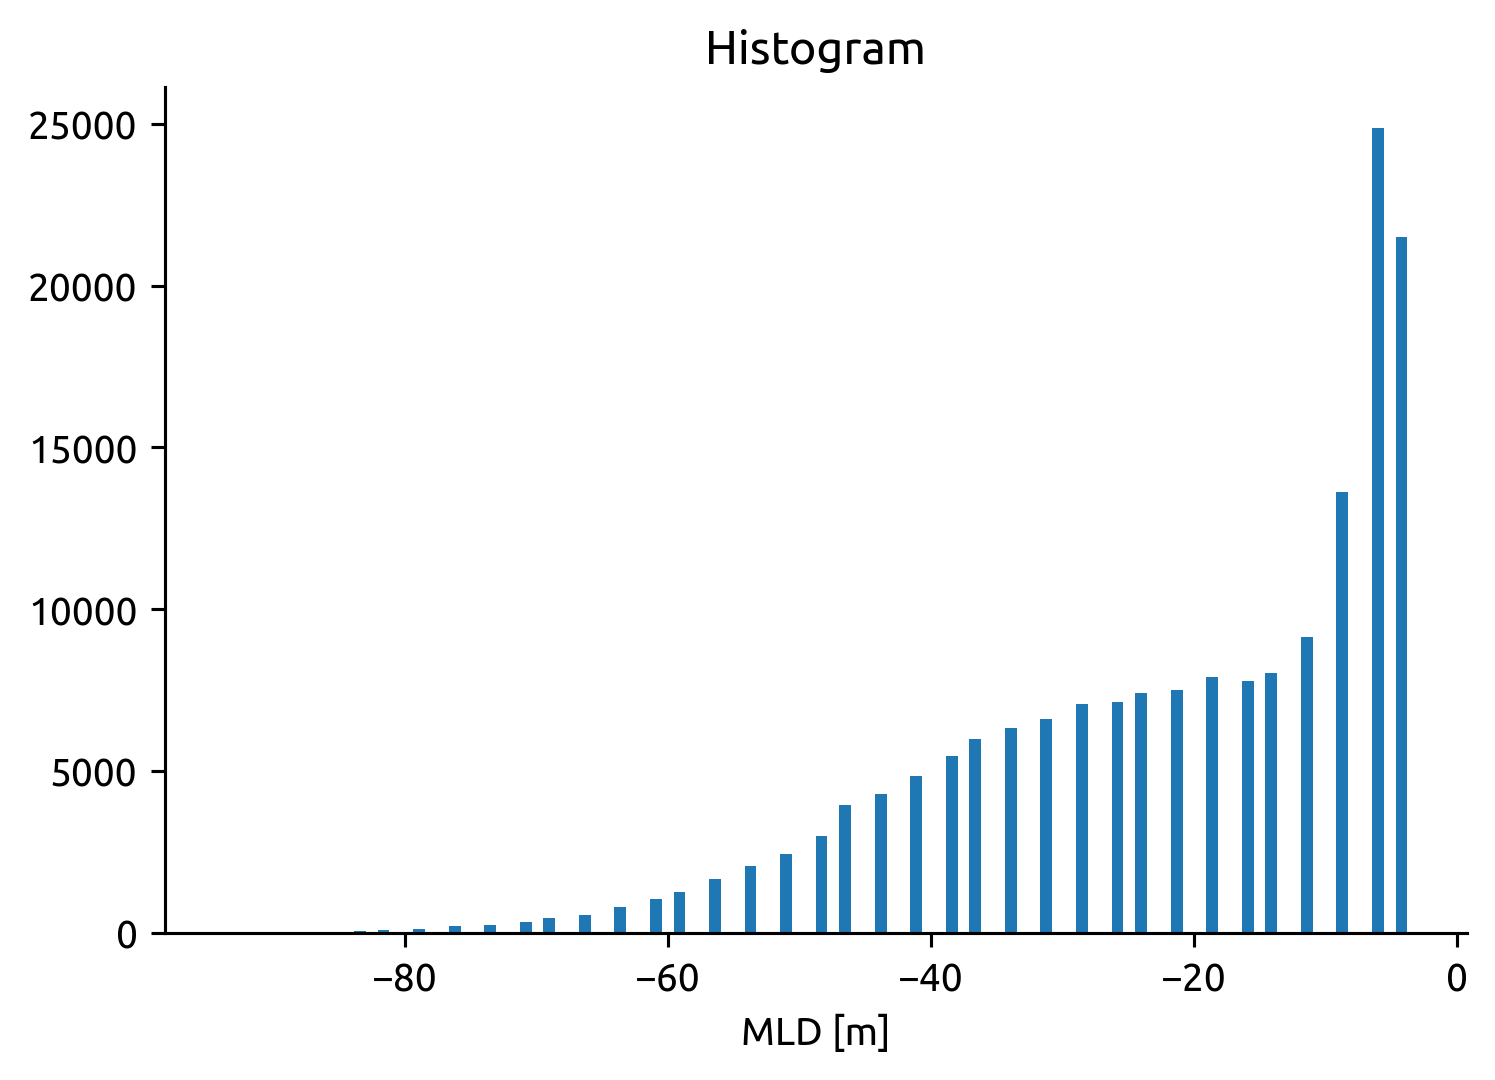

In [7]:
station.mld.plot.hist(bins=100);

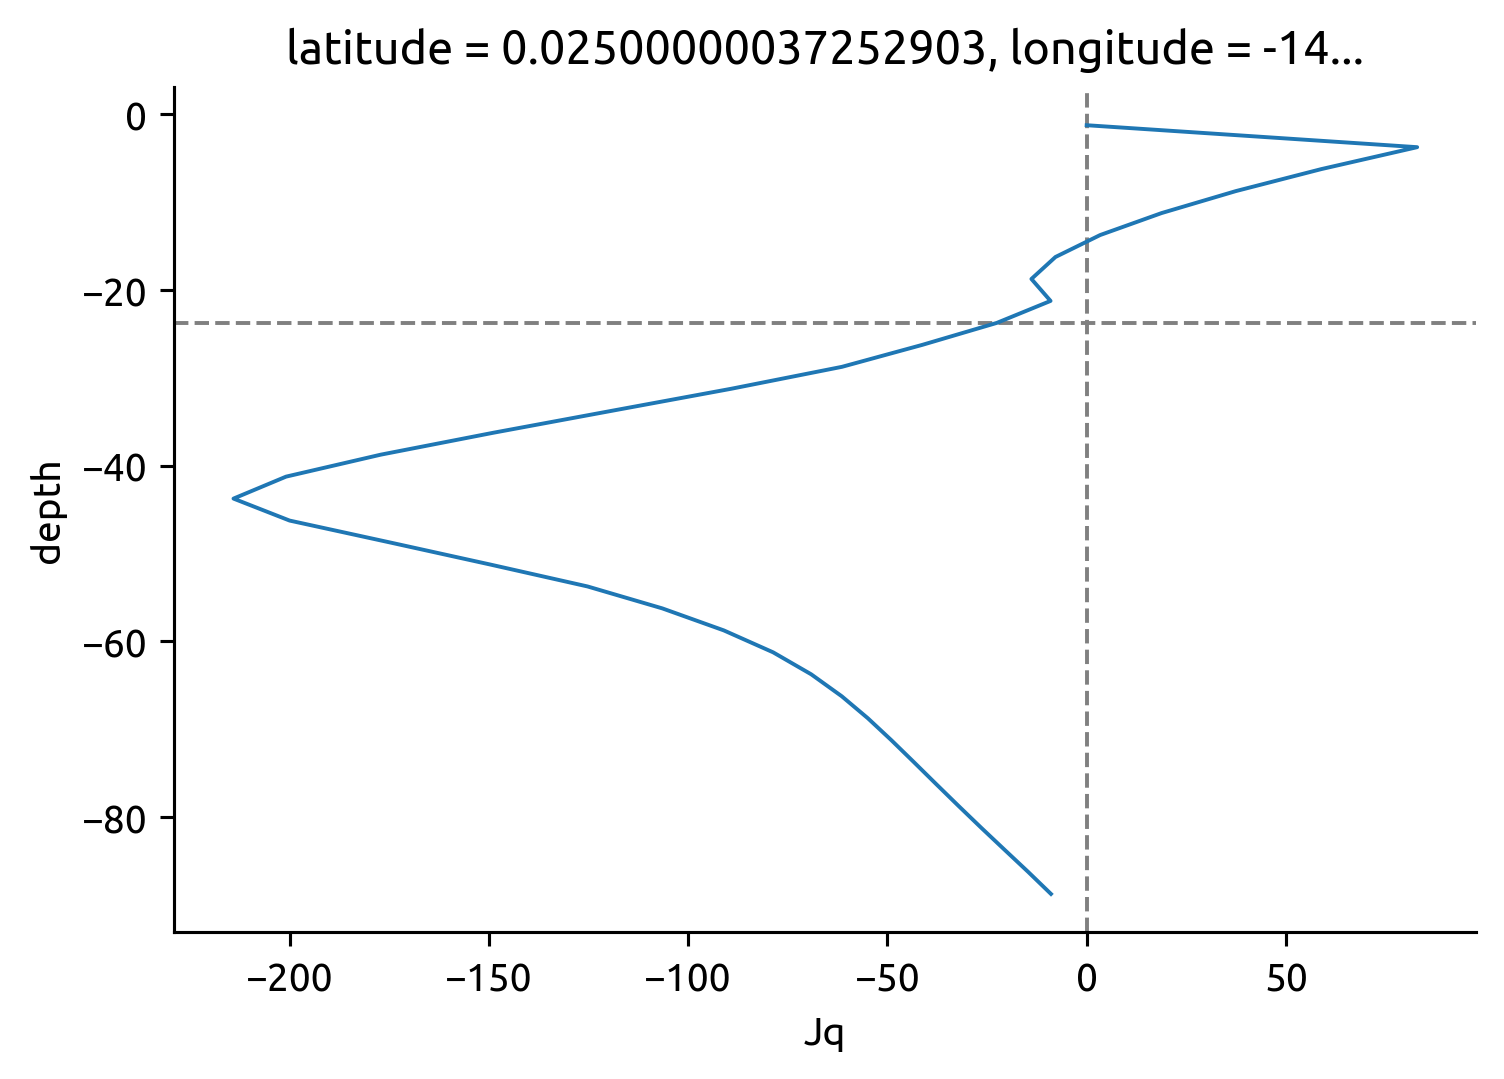

In [9]:
station.Jq.sel(depth=slice(-90)).isel(time=10400).cf.plot(y="depth")
dcpy.plots.liney(station.mld.isel(time=100))
dcpy.plots.linex(0)

In [11]:
timemean = regridded.mean("time").compute()

In [12]:
z0 = station.eucmax.mean("time")
# timemean["zeuc"] = timemean.zeuc - z0

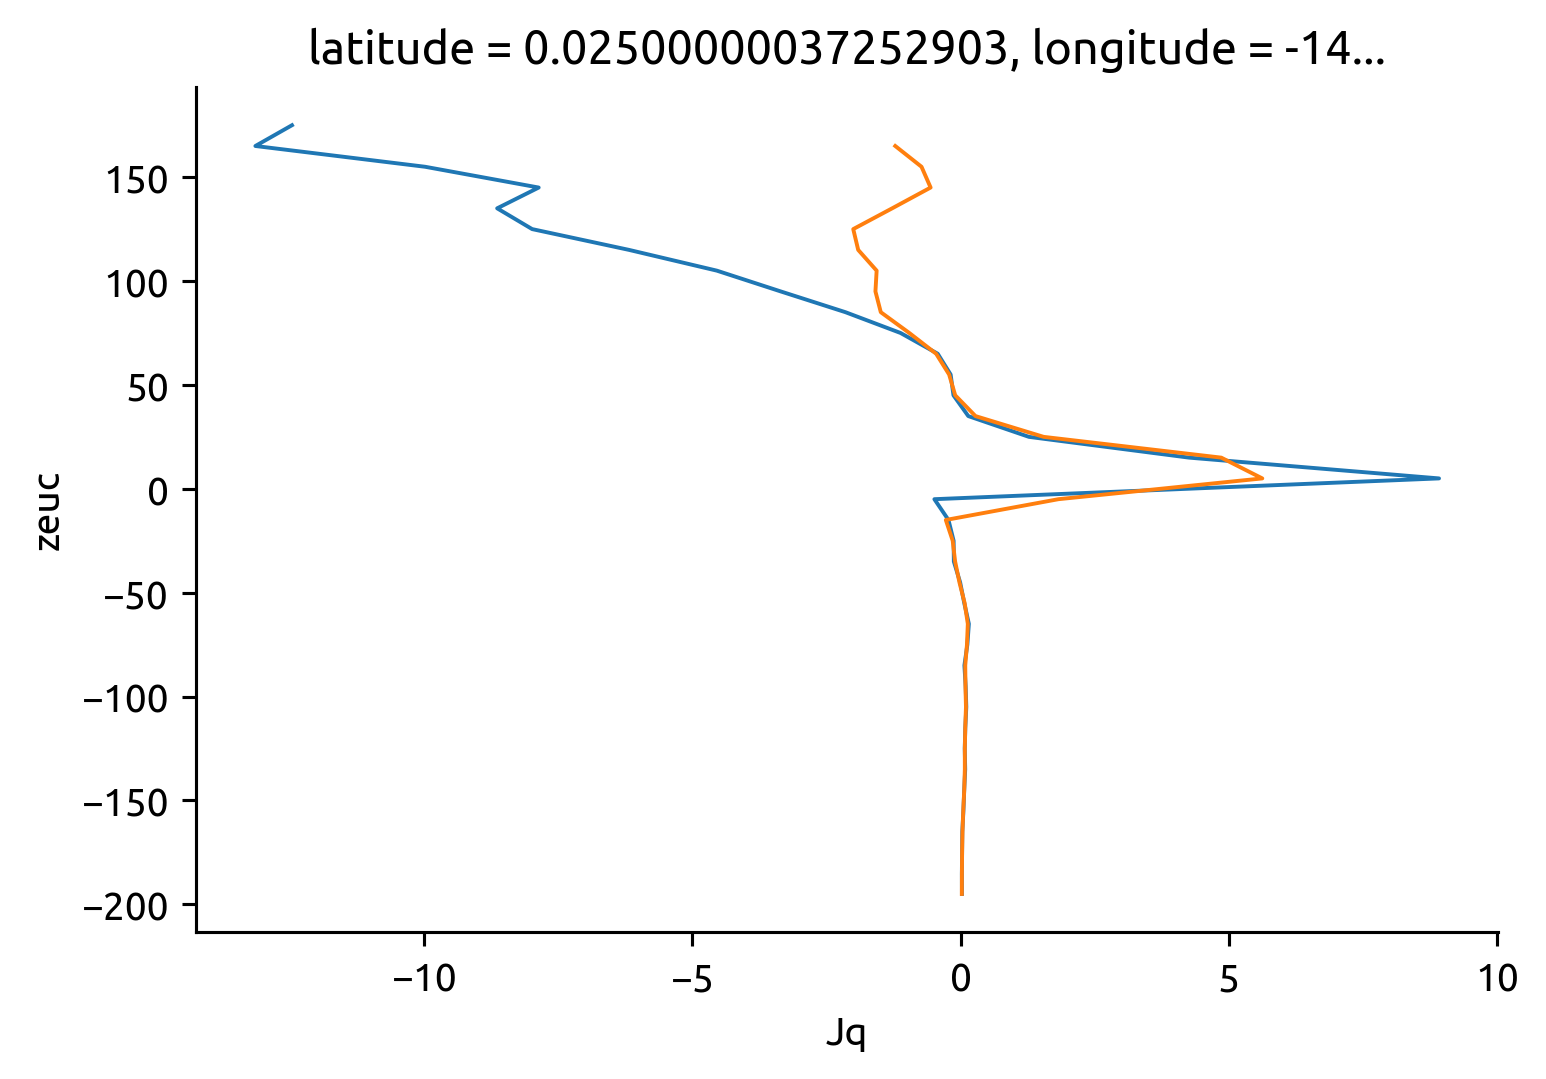

In [13]:
(-1 * timemean.dJdz).plot(y="zeuc")
(-1 * timemean.Jq.differentiate("zeuc")).plot(y="zeuc")

In [17]:
station.mld.load()

<xarray.DataArray 'mld' (time: 174000)>
array([-3.75, -6.25, -6.25, ..., -3.75, -6.25, -6.25], dtype=float32)
Coordinates:
    latitude   float64 0.025
    longitude  float64 -140.0
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00
Attributes:
    long_name:    MLD
    units:        m
    description:  Interpolate density to 1m grid. Search for max depth where ...

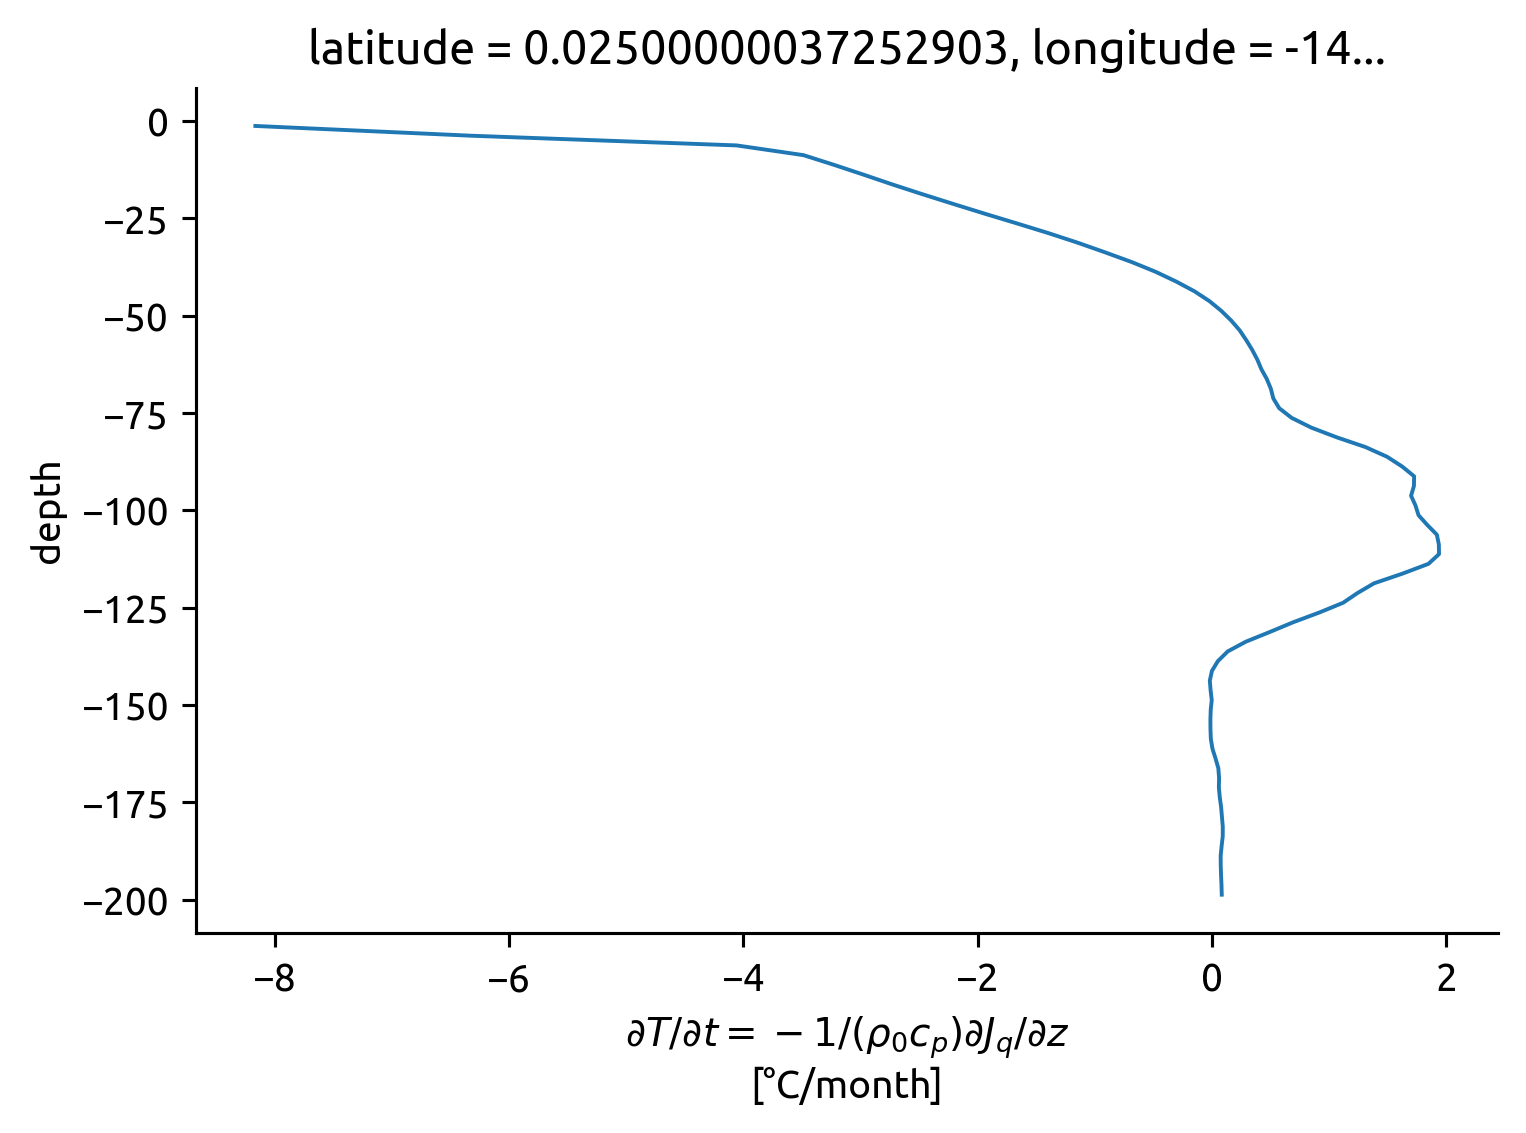

In [23]:
station.dTdt.sel(depth=slice(-200)).mean("time").cf.plot()

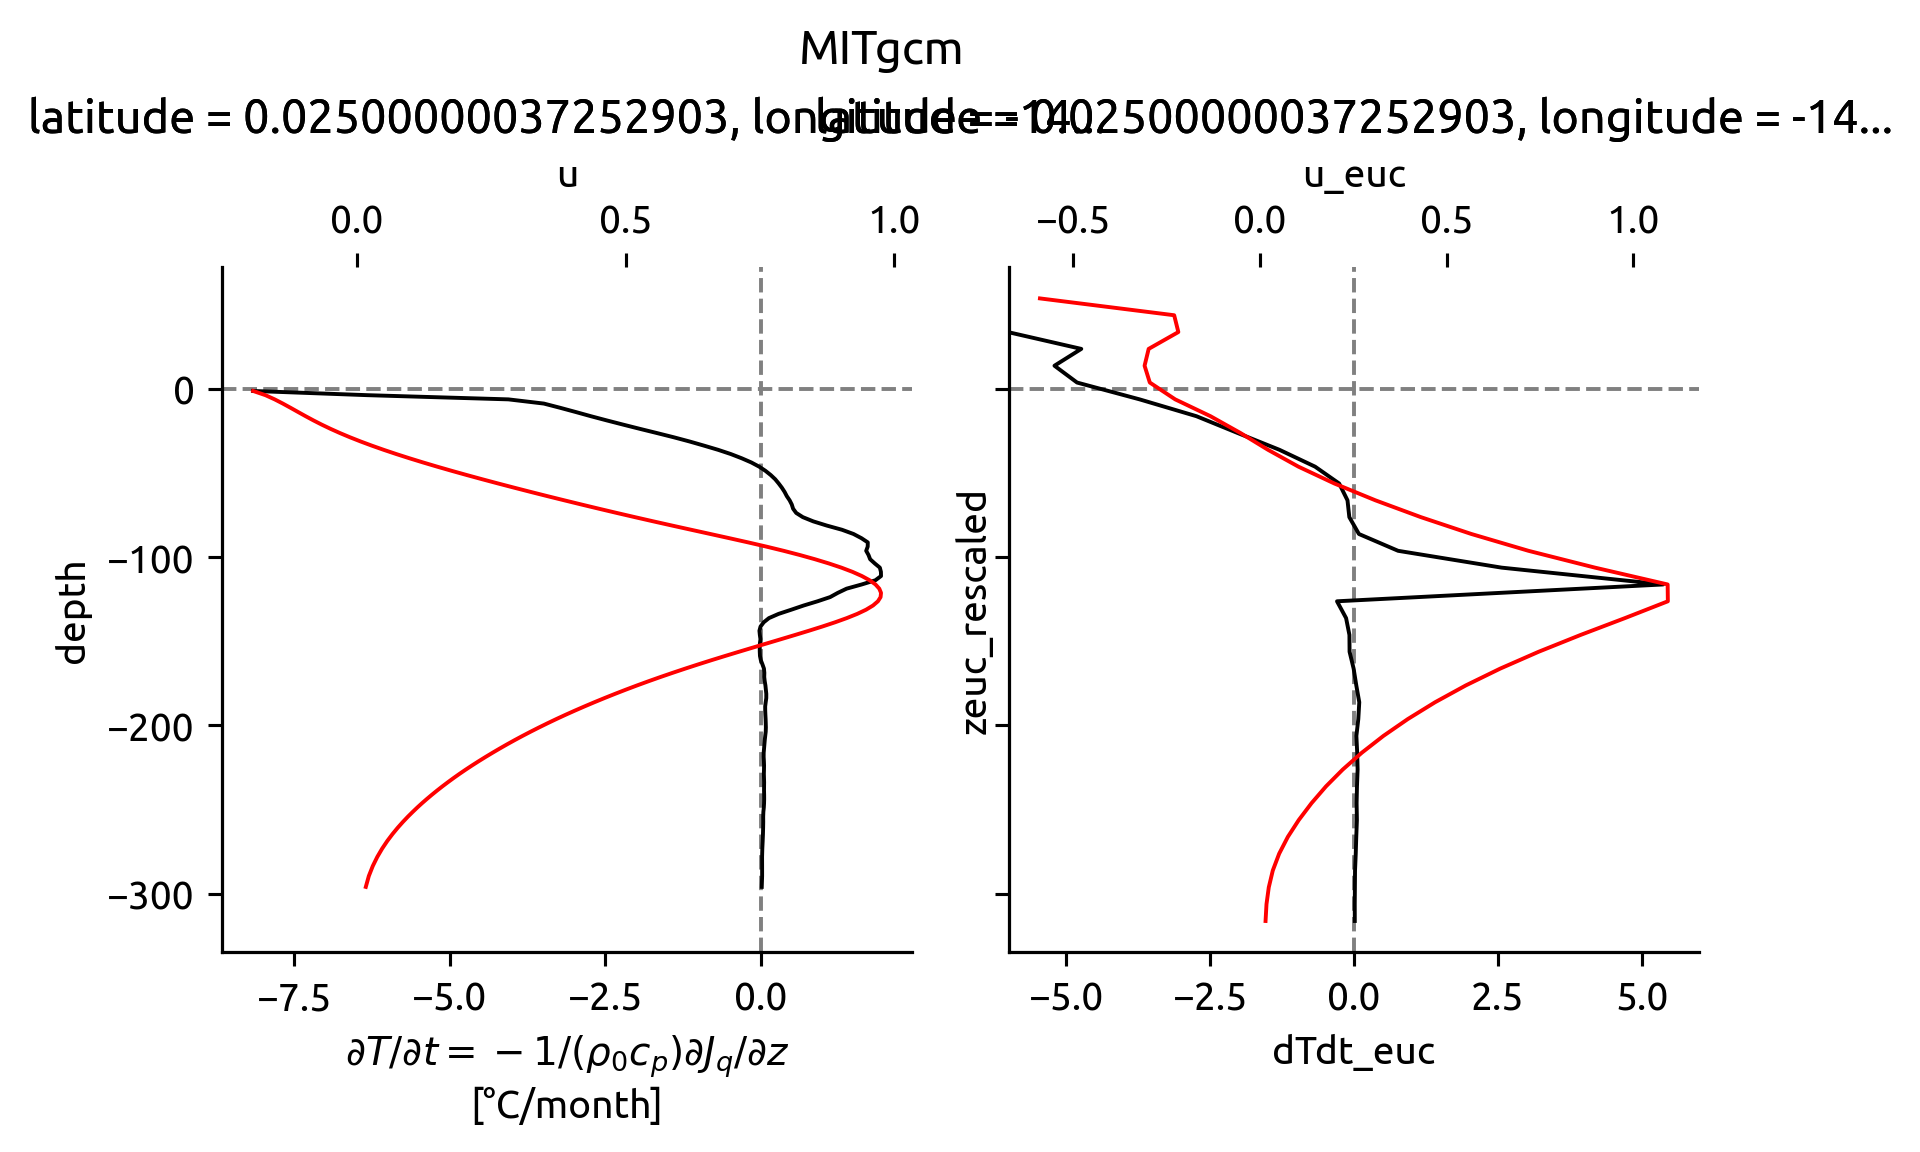

In [9]:
def plot_flux_profiles(ds):
    f, ax = plt.subplots(1, 2, constrained_layout=True, sharey=True)
    ds.dTdt.mean("time").cf.plot(ax=ax[0], color="k")
    ds.u.mean("time").cf.plot(ax=ax[0].twiny(), color="r")

    mean_zeuc = station.u.mean("time").idxmax("depth")
    ds.coords["zeuc_rescaled"] = ds.zeuc + mean_zeuc
    ds.dTdt_euc.mean("time").cf.plot(
        y="zeuc_rescaled", ax=ax[1], xlim=(-6, 6), color="k"
    )
    ds.u_euc.mean("time").cf.plot(y="zeuc_rescaled", ax=ax[1].twiny(), color="r")

    for axx in ax:
        dcpy.plots.linex(0, axx)
        dcpy.plots.liney(0, axx)

    f.suptitle(ds.attrs["name"])


plot_flux_profiles(station.sel(depth=slice(-300)))

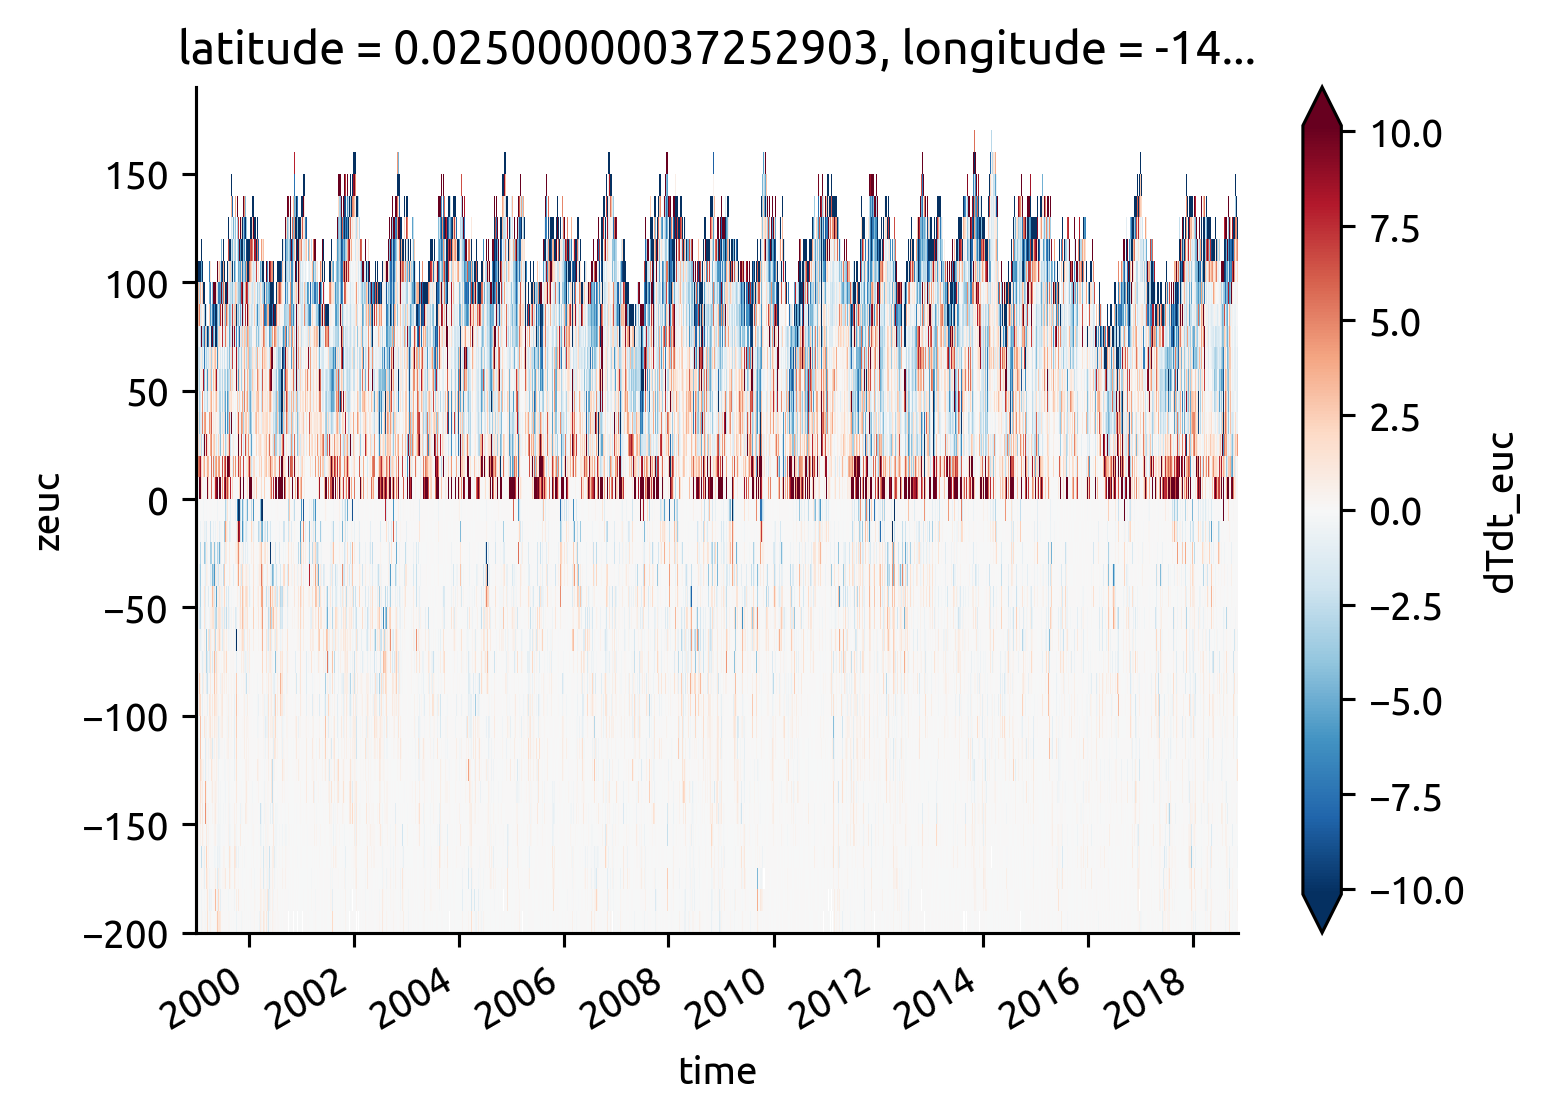

In [12]:
station.dTdt_euc.cf.plot(robust=True)

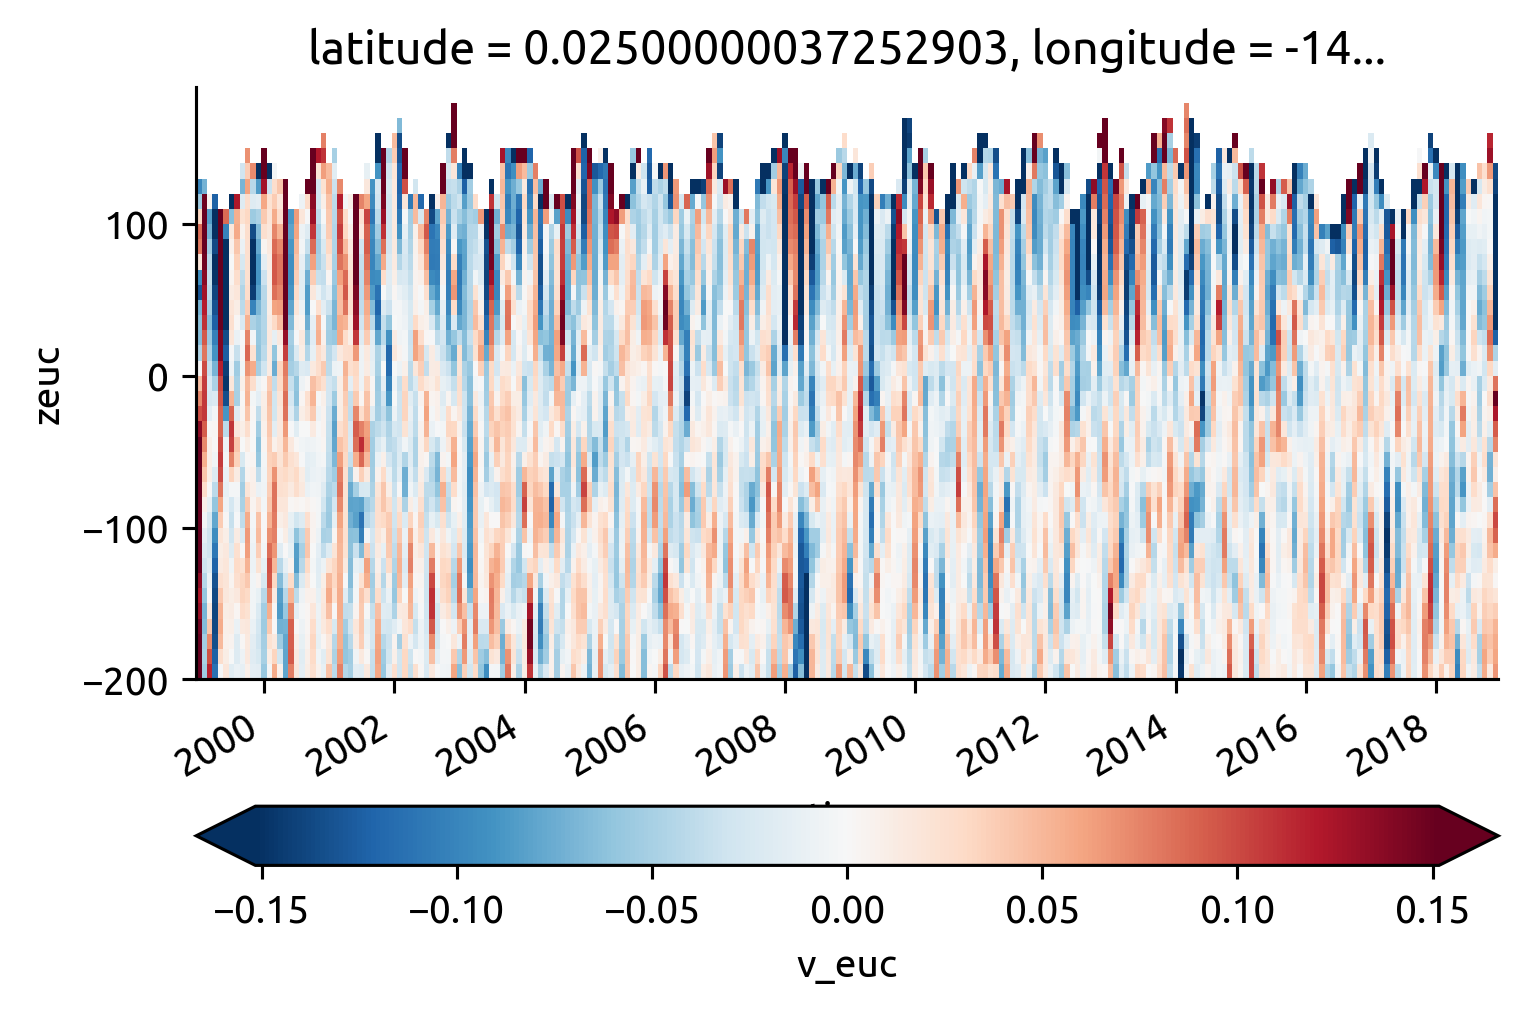

In [24]:
station.v_euc.resample(time="M").mean("time").cf.plot(robust=True, cbar_kwargs={"orientation": "horizontal"})

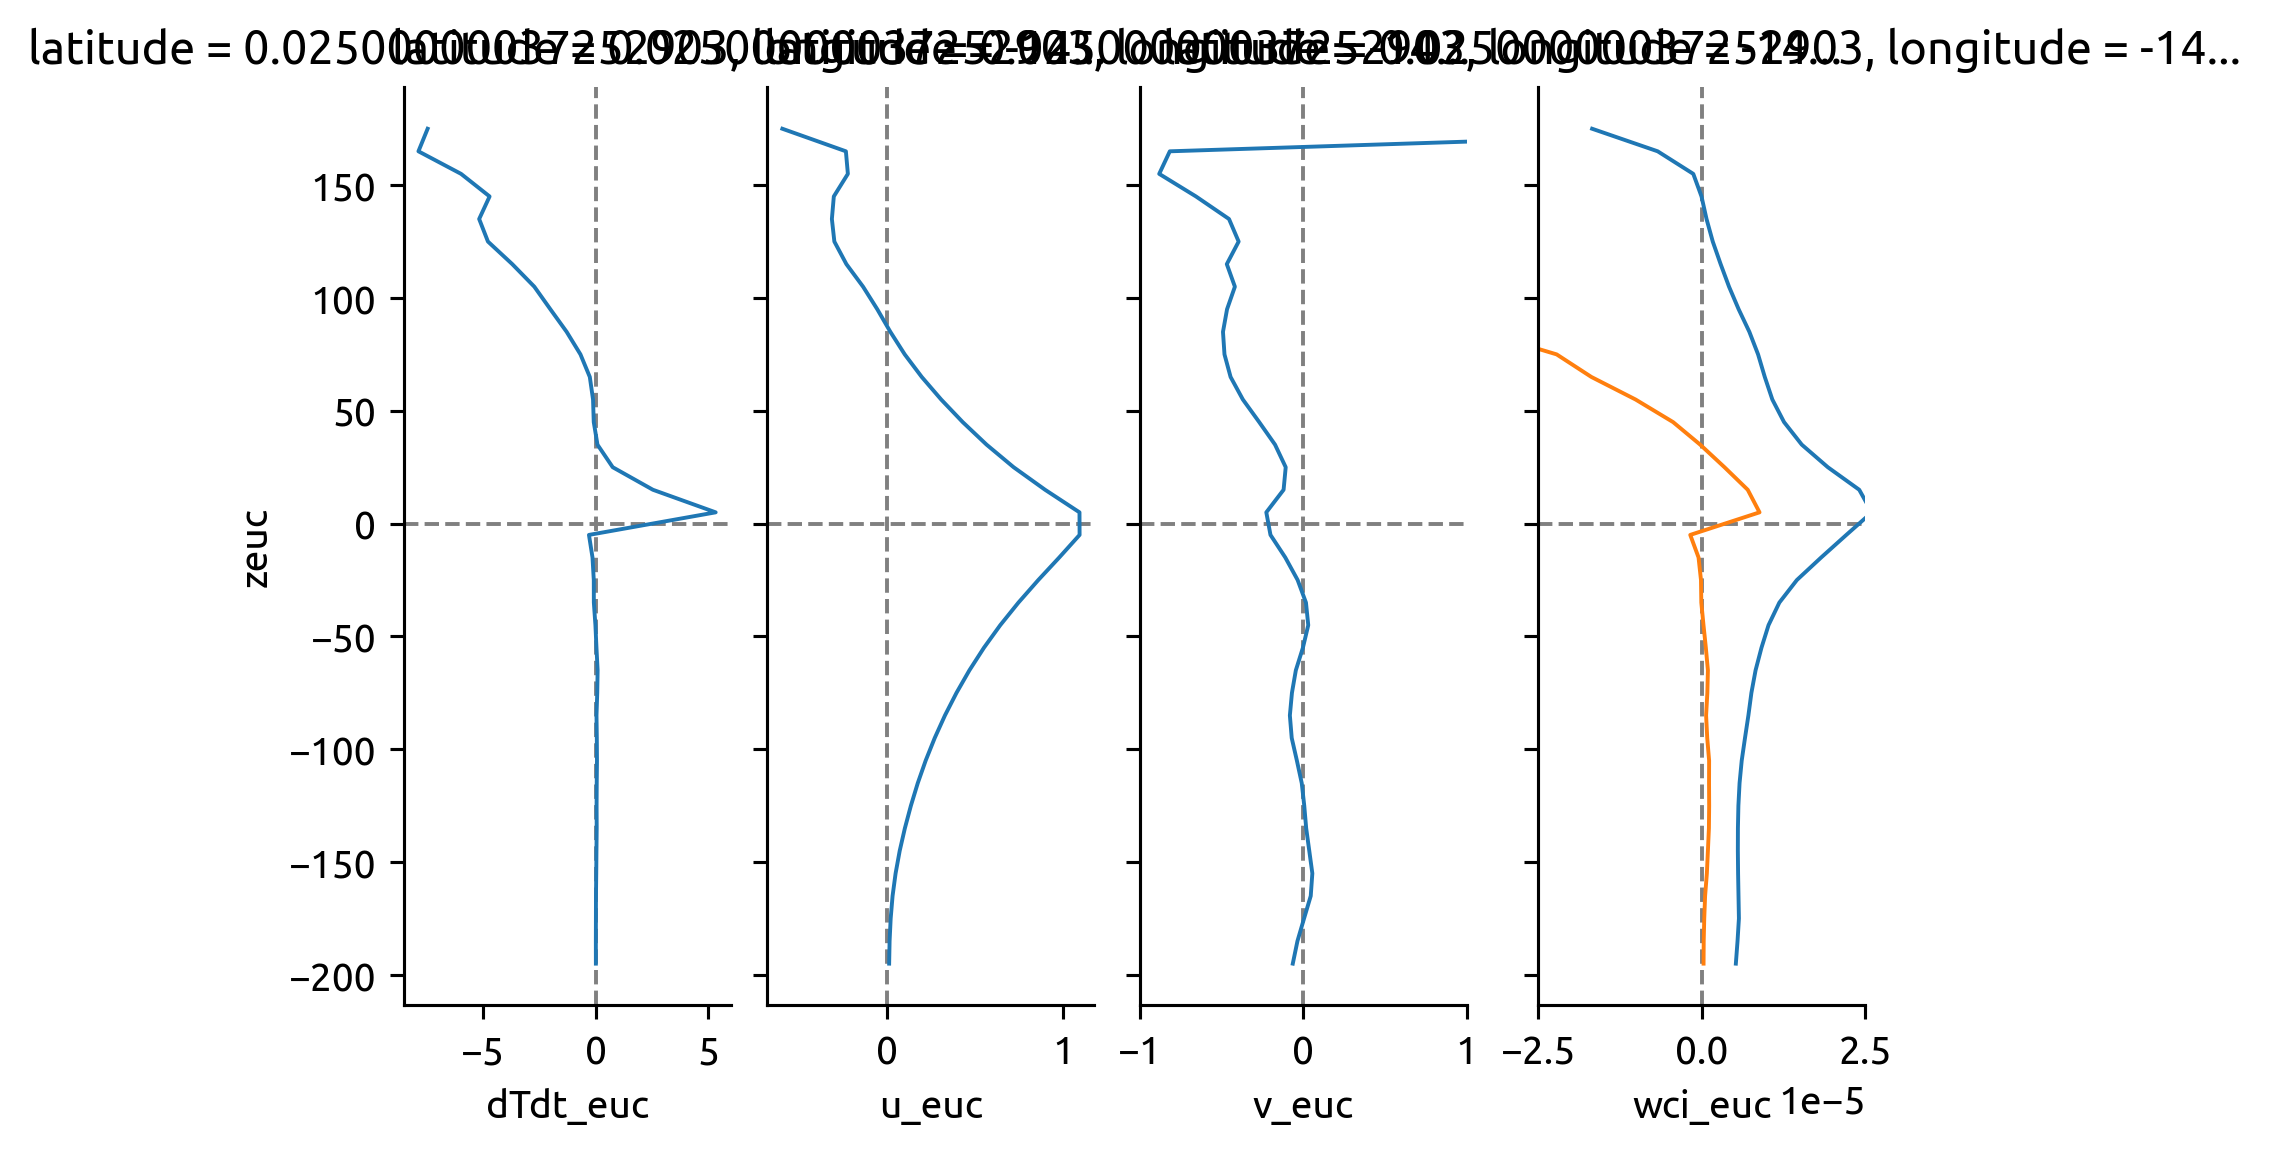

In [67]:
f, axx = plt.subplots(1, 4, sharey=True, constrained_layout=True)

station.dTdt_euc.mean("time").cf.plot(ax=axx[0])
station.u_euc.mean("time").cf.plot(ax=axx[1])
(20 * station.v_euc).mean("time").cf.plot(ax=axx[2], xlim=[-1, 1])
(station.w_euc).mean("time").cf.plot(ax=axx[3])
(station.wci_euc).mean("time").cf.plot(ax=axx[3], xlim=[-2.5e-5, 2.5e-5])

dcpy.plots.linex(0, axx)
dcpy.plots.liney(0, axx)
dcpy.plots.clean_axes(axx)

## TPON figure

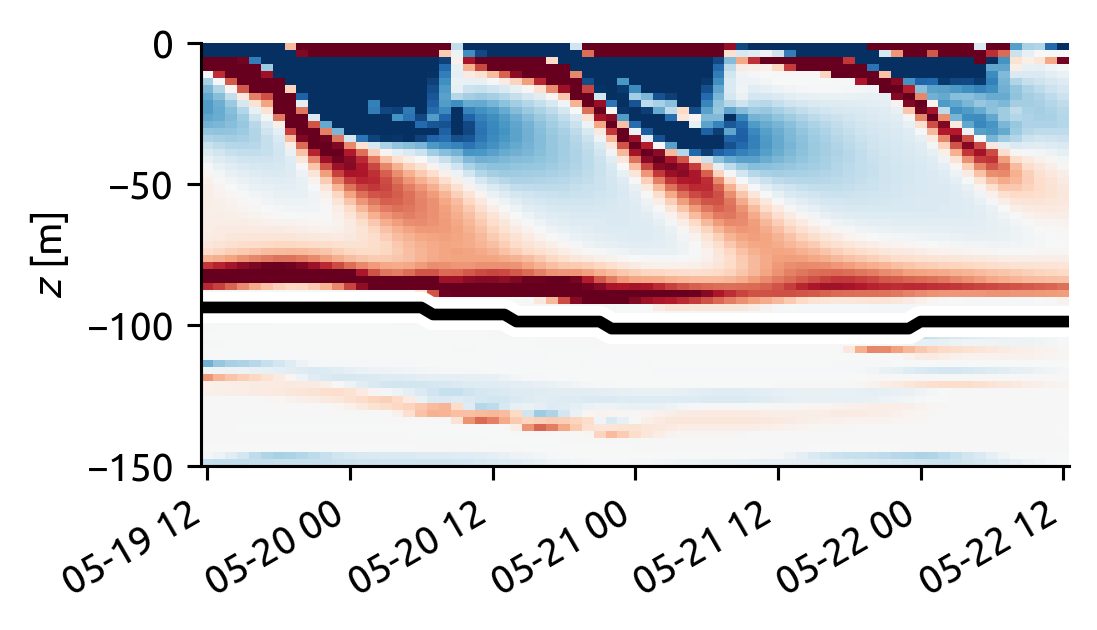

In [72]:
subset = station.sel(time=slice("2002-05-19 12:00", "2002-05-22 12:00"))

subset.dTdt.plot(
    robust=True,
    ylim=(-150, 0),
    add_colorbar=False,
    # cbar_kwargs={"orientation": "horizontal"},
)
plt.gca().set_xlabel("")
plt.gca().set_ylabel("$z$ [m]")
plt.gca().set_title("")
plt.gcf().set_size_inches((4, 2))
subset.eucmax.plot(x="time", color="w", lw=8, _labels=False)
subset.eucmax.plot(x="time", color="k", lw=3, _labels=False)

(array([  444.,  5207., 21865., 30073., 42728., 32279., 28637.,  9808.,
         2659.,   300.]),
 array([ 30.  ,  43.75,  57.5 ,  71.25,  85.  ,  98.75, 112.5 , 126.25,
        140.  , 153.75, 167.5 ], dtype=float32),
 <BarContainer object of 10 artists>)

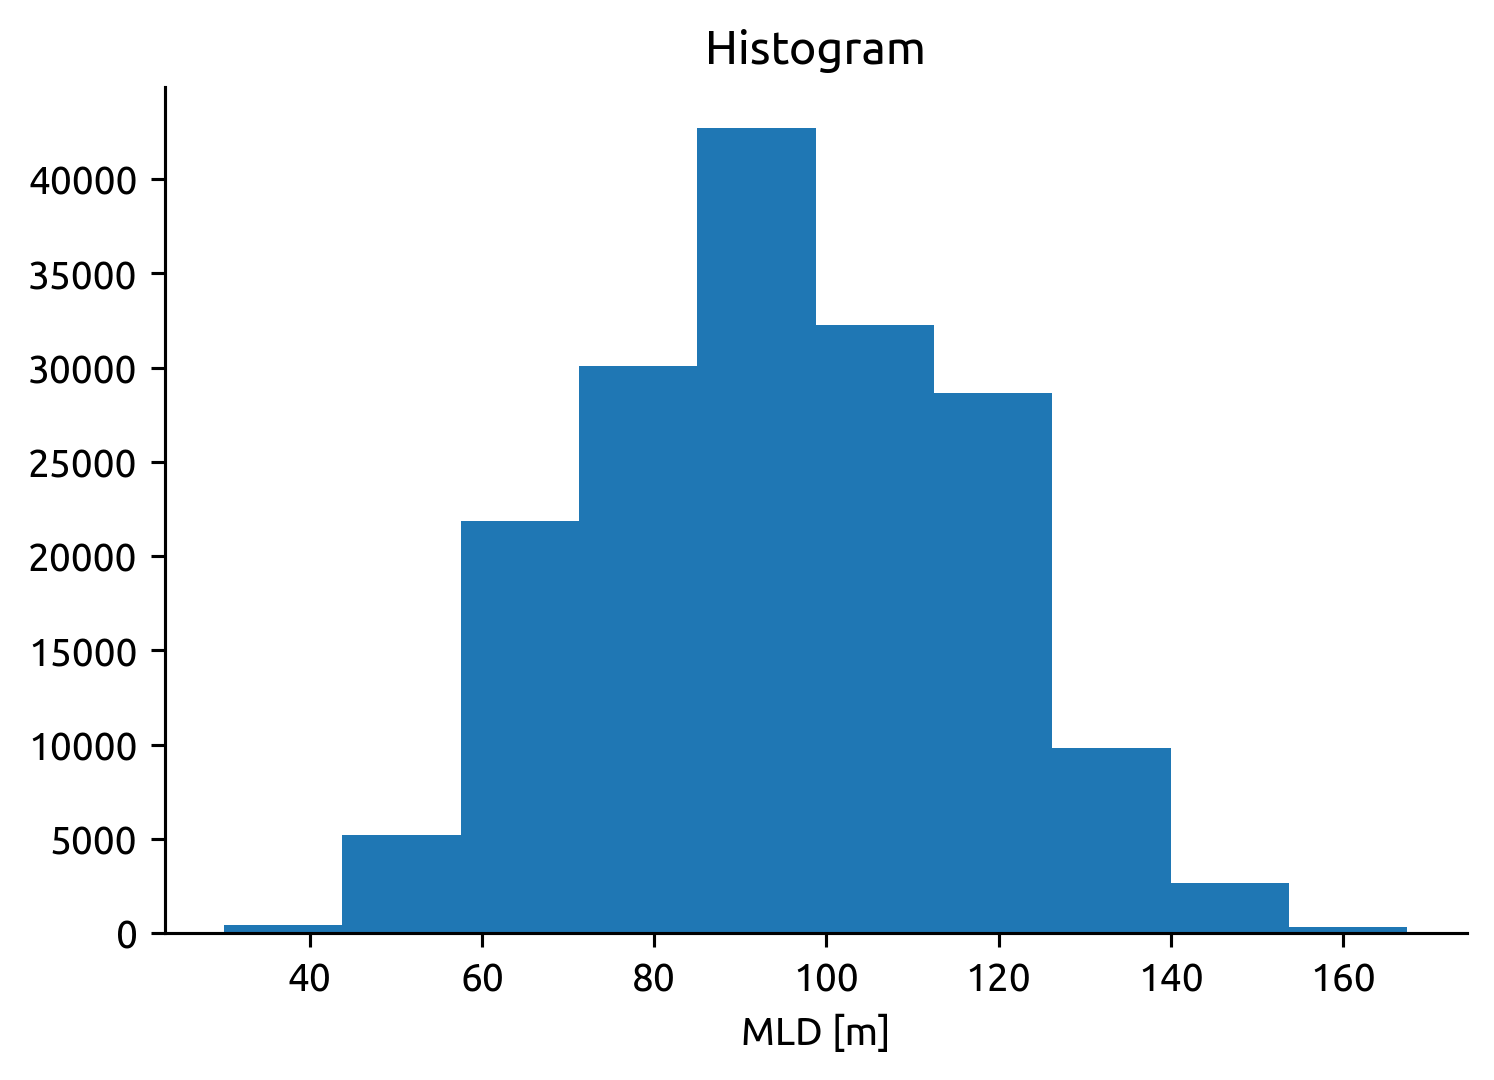

In [52]:
# mld range in z-z_euc coordinates

(station.mld - station.eucmax).plot.hist()

## χpod

In [100]:
import xarray as xr
from xarray import DataArray, Dataset

xr.set_options(display_style="text")
keys = ["foo", 1]
ds = Dataset()
for key in keys:
    ds[key] = DataArray()

ds[["foo", 1]]

KeyError: '1'

In [25]:
chipod = dcpy.oceans.read_cchdo_chipod_file(
    file="/home/deepak/datasets/microstructure/osu/chipods_0_140W.nc"
)
chipod

<xarray.Dataset>
Dimensions:     (depth: 7, time: 107588)
Coordinates:
    timeSeries  (depth) float64 ...
  * time        (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:2...
    lat         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
    lon         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
  * depth       (depth) float64 29.0 39.0 49.0 59.0 69.0 89.0 119.0
Data variables:
    T           (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    dTdz        (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    N2          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    KT          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    chi         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    eps         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    Jq          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
Attributes: (12/68)
    ncei_template_version:           NCEI_NetCDF_TimeSeries_Orthogonal_Templa...
    featureType:                     timeSeries
    title:                           Turbulence quantities measured by chipod...
    summary:                         Turbulence data in upper w m / all good ...
    keywords:                        sea_water_temperature, square_of_brunt_v...
    Conventions:                     CF-1.6, ACDD-1.3
    ...                              ...
    reference8:                      Moum, J.N., Ocean speed and turbulence m...
    reference9:                      Warner, S.J., J. Becherer, K. Pujiana, E...
    reference10:                     Moum, J.N., K. Pujiana, R-C. Lien and W....
    reference11:                     Becherer, J. and J.N. Moum, An efficient...
    reference12:                     Moulin, A.J., J.N. Moum and E.L. Shroyer...
    reference13:                     Thakur, R., E.L. Shroyer, R. Govindaraja...

In [26]:
adcp = (
    pump.obs.read_tao_adcp(
        freq="hr", dirname="/home/deepak/TaoTritonPirataRama/high_resolution/hr/"
    )
    .sel(longitude=-140)
    .interp(time=chipod.time)
    .rename({"depth": "adcp_depth"})
)
adcp

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


<xarray.Dataset>
Dimensions:     (adcp_depth: 117, time: 107588)
Coordinates:
  * adcp_depth  (adcp_depth) float64 -0.0 -10.0 -15.0 ... -580.0 -590.0 -600.0
    latitude    float32 0.0
    longitude   float64 -140.0
  * time        (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:2...
Data variables:
    u           (time, adcp_depth) float32 dask.array<chunksize=(107588, 117), meta=np.ndarray>
    v           (time, adcp_depth) float32 dask.array<chunksize=(107588, 117), meta=np.ndarray>
Attributes:
    platform_code:                0n156e
    site_code:                    0n156e
    wmo_platform_code:            52317
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                23:25 24-FEB-2021

In [29]:
chipod = chipod.merge(adcp)

chipod["depth"] = chipod.depth * -1

chipod["eucmax"] = pump.calc.get_euc_max(chipod.u, kind="data")
chipod.coords["zeuc"] = chipod.depth - chipod.eucmax

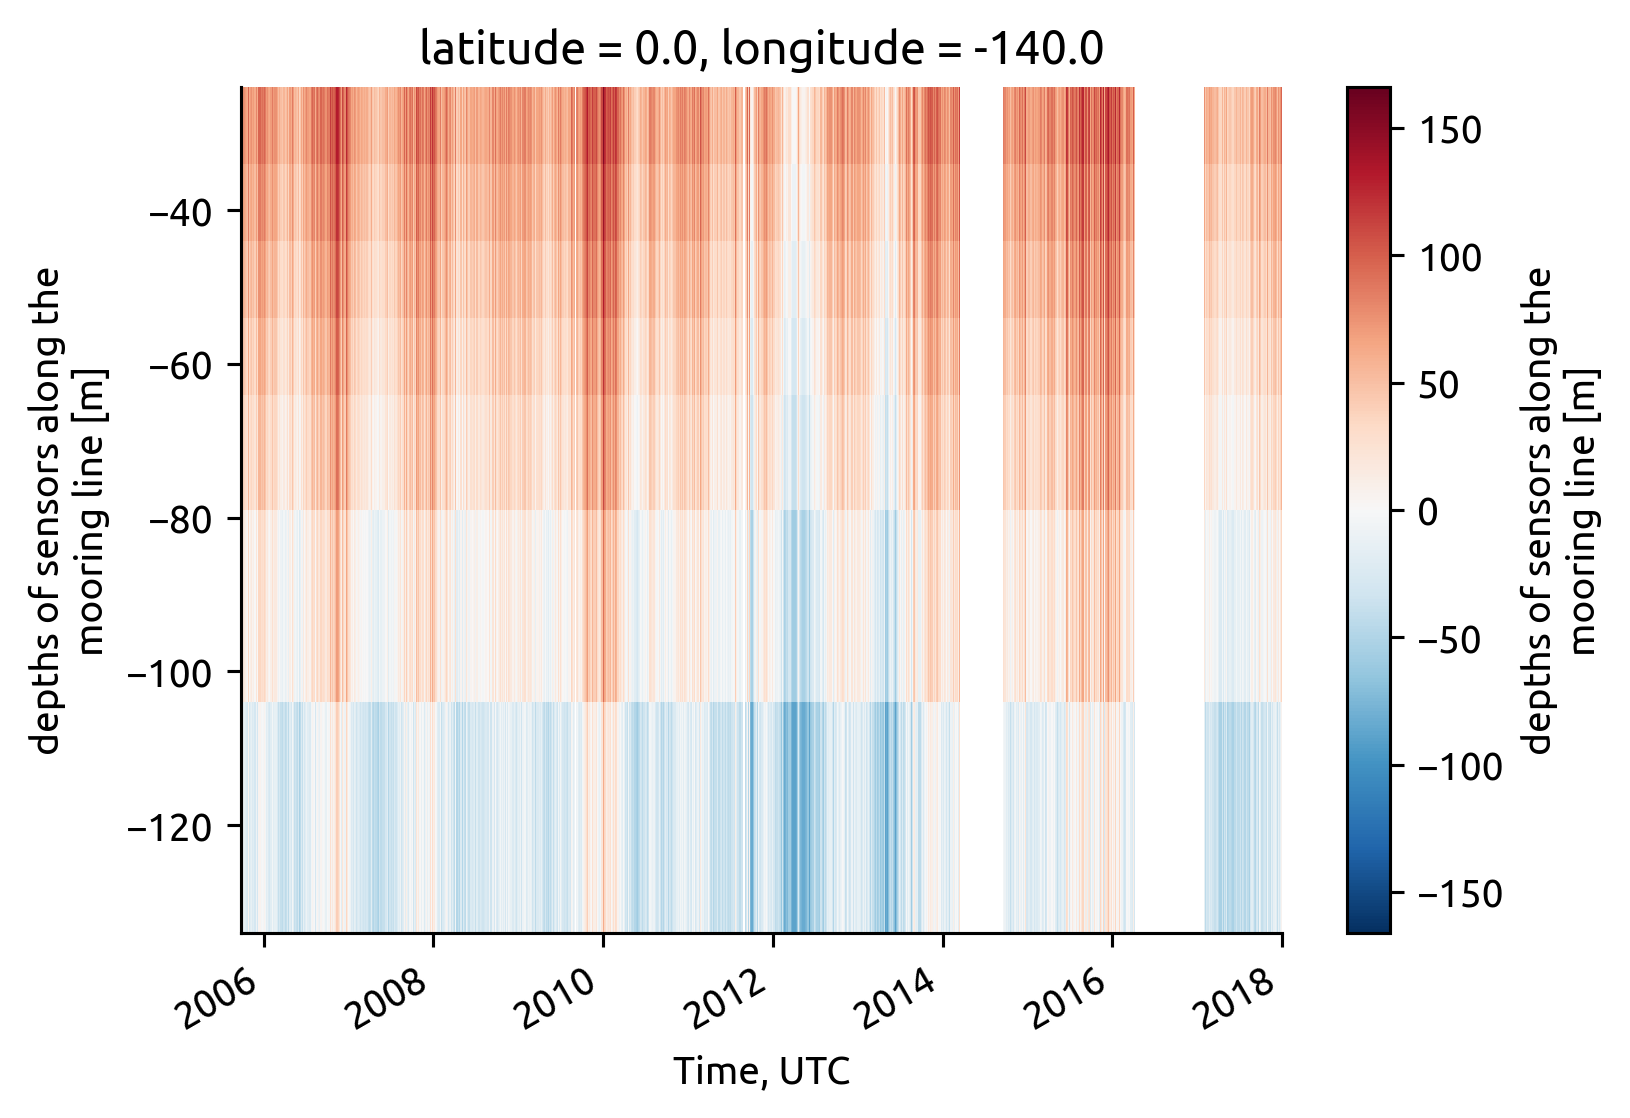

In [31]:
chipod.zeuc.plot(x="time")

In [32]:
chipod

<xarray.Dataset>
Dimensions:     (adcp_depth: 117, depth: 7, time: 107588)
Coordinates:
    timeSeries  (depth) float64 ...
  * time        (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:2...
    lat         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
    lon         (depth) float64 dask.array<chunksize=(7,), meta=np.ndarray>
  * depth       (depth) float64 -29.0 -39.0 -49.0 -59.0 -69.0 -89.0 -119.0
  * adcp_depth  (adcp_depth) float64 -0.0 -10.0 -15.0 ... -580.0 -590.0 -600.0
    latitude    float32 0.0
    longitude   float64 -140.0
    zeuc        (depth, time) float64 96.0 101.0 101.0 ... -14.0 -14.0 -9.0
Data variables:
    T           (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    dTdz        (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    N2          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    KT          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    chi         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    eps         (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    Jq          (depth, time) float64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    u           (time, adcp_depth) float32 dask.array<chunksize=(107588, 117), meta=np.ndarray>
    v           (time, adcp_depth) float32 dask.array<chunksize=(107588, 117), meta=np.ndarray>
    eucmax      (time) float64 -125.0 -130.0 -130.0 ... -105.0 -105.0 -110.0
Attributes: (12/68)
    ncei_template_version:           NCEI_NetCDF_TimeSeries_Orthogonal_Templa...
    featureType:                     timeSeries
    title:                           Turbulence quantities measured by chipod...
    summary:                         Turbulence data in upper w m / all good ...
    keywords:                        sea_water_temperature, square_of_brunt_v...
    Conventions:                     CF-1.6, ACDD-1.3
    ...                              ...
    reference8:                      Moum, J.N., Ocean speed and turbulence m...
    reference9:                      Warner, S.J., J. Becherer, K. Pujiana, E...
    reference10:                     Moum, J.N., K. Pujiana, R-C. Lien and W....
    reference11:                     Becherer, J. and J.N. Moum, An efficient...
    reference12:                     Moulin, A.J., J.N. Moum and E.L. Shroyer...
    reference13:                     Thakur, R., E.L. Shroyer, R. Govindaraja...

In [33]:
adcp.coords["zeuc"] = adcp.adcp_depth - chipod.eucmax

In [34]:
chipod_regridded = dcpy.interpolate.bin_to_new_coord(
    chipod[["chi", "Jq", "eps", "T"]], "depth", "zeuc", np.arange(-200, 200, 20)
).load()
chipod_regridded = chipod_regridded.merge(
    dcpy.interpolate.bin_to_new_coord(
        adcp, "adcp_depth", "zeuc", np.arange(-200, 200, 20)
    ).load()
)
chipod_regridded

<xarray.Dataset>
Dimensions:    (time: 107588, zeuc: 19)
Coordinates:
  * time       (time) datetime64[ns] 2005-09-23T04:30:00 ... 2017-12-31T23:29...
    latitude   float32 0.0
    longitude  float64 -140.0
  * zeuc       (zeuc) float64 -190.0 -170.0 -150.0 -130.0 ... 130.0 150.0 170.0
Data variables:
    chi        (time, zeuc) float64 nan nan nan nan nan ... nan nan nan nan nan
    Jq         (time, zeuc) float64 nan nan nan nan nan ... nan nan nan nan nan
    eps        (time, zeuc) float64 nan nan nan nan nan ... nan nan nan nan nan
    T          (time, zeuc) float64 nan nan nan nan nan ... nan nan nan nan nan
    count_chi  (time, zeuc) int64 0 0 0 0 0 0 0 0 0 0 1 ... 1 0 1 2 2 1 0 0 0 0
    count_Jq   (time, zeuc) int64 0 0 0 0 0 0 0 0 0 0 1 ... 1 0 1 2 2 1 0 0 0 0
    count_eps  (time, zeuc) int64 0 0 0 0 0 0 0 0 0 0 1 ... 1 0 1 2 2 1 0 0 0 0
    count_T    (time, zeuc) int64 0 0 0 0 0 0 0 0 0 0 1 ... 1 0 1 2 2 1 0 0 0 0
    u          (time, zeuc) float64 nan nan nan nan -0.014 ... nan nan nan nan
    v          (time, zeuc) float64 nan nan nan nan 0.3155 ... nan nan nan nan
    count_u    (time, zeuc) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 2 0 0 0
    count_v    (time, zeuc) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 2 0 0 0

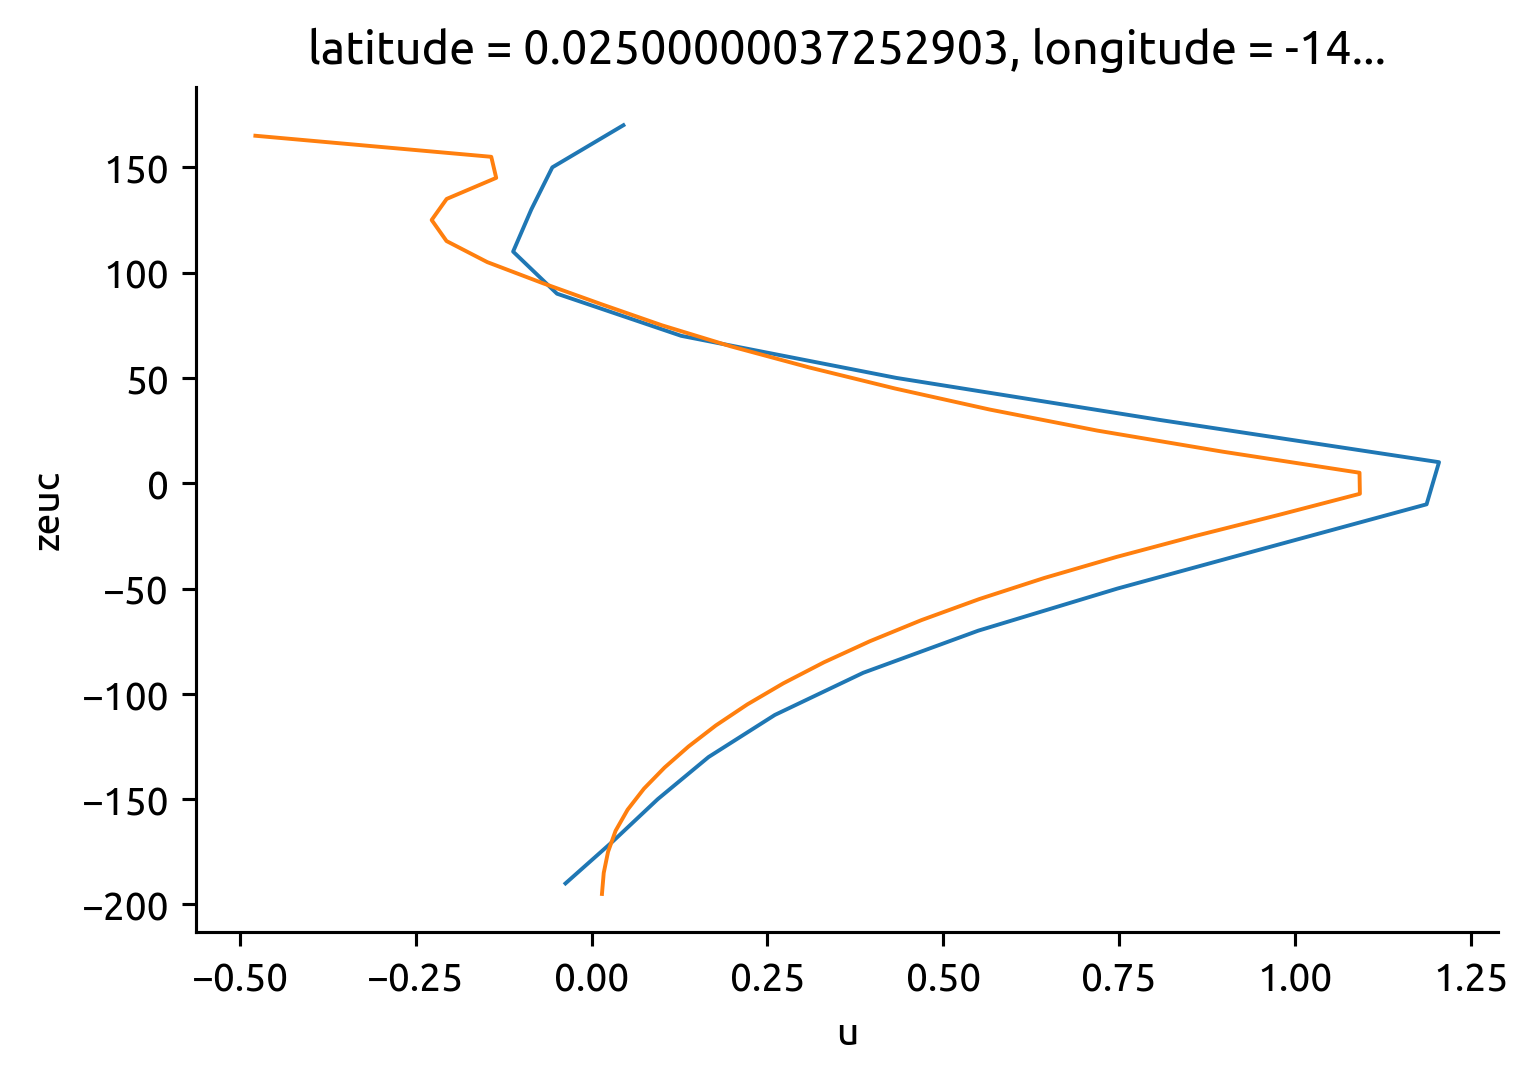

In [147]:
chipod_regridded.u.mean("time").plot(y="zeuc")
timemean.u.plot(y="zeuc")

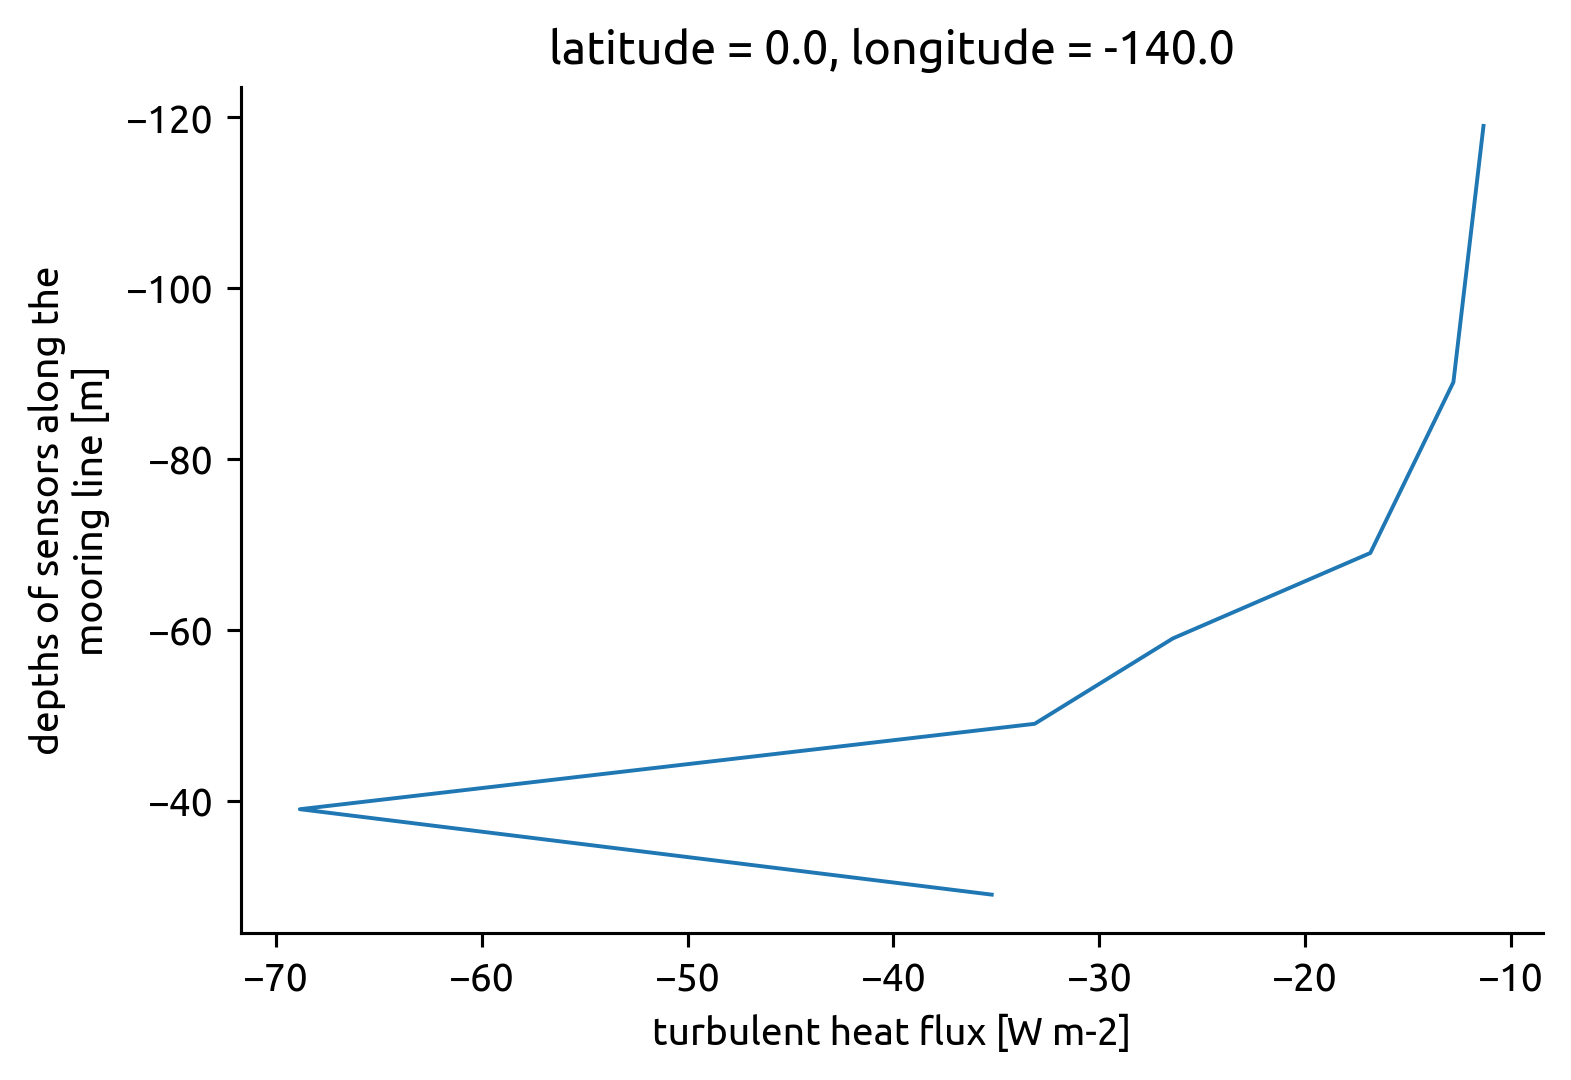

In [54]:
chipod.Jq.mean("time").cf.plot(y="Z", x=None)

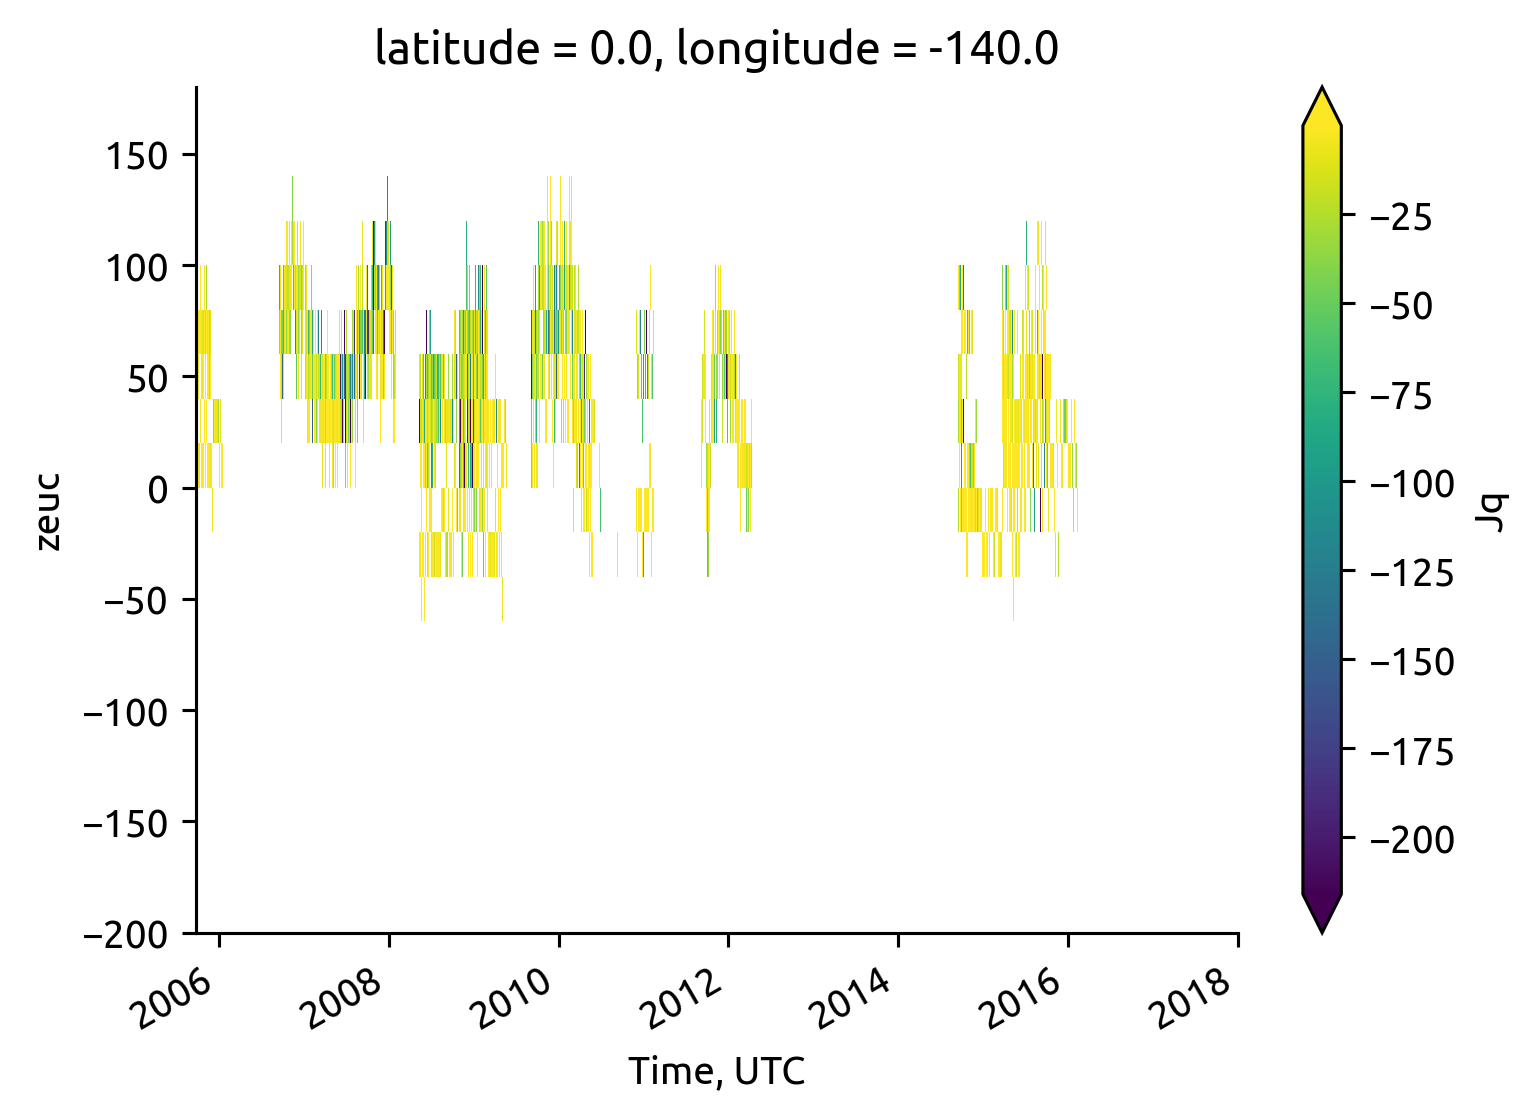

In [55]:
chipod_regridded.Jq.plot(robust=True, x="time")

In [58]:
daily_chipod = chipod.coarsen(time=24, boundary="trim").mean()

In [60]:
daily_station = regridded.coarsen(time=24, boundary="trim").mean()

In [64]:
daily_chipod["time"] = daily_chipod.time.dt.floor("D")

In [65]:
daily_station["time"] = daily_station.time.dt.floor("D")

In [66]:
masked = daily_station.where(daily_chipod.count("depth") > 3)

In [ ]:
chipod_regridded.Jq.mean("time").plot(y="zeuc")
masked.Jq.mean("time").plot(y="zeuc")

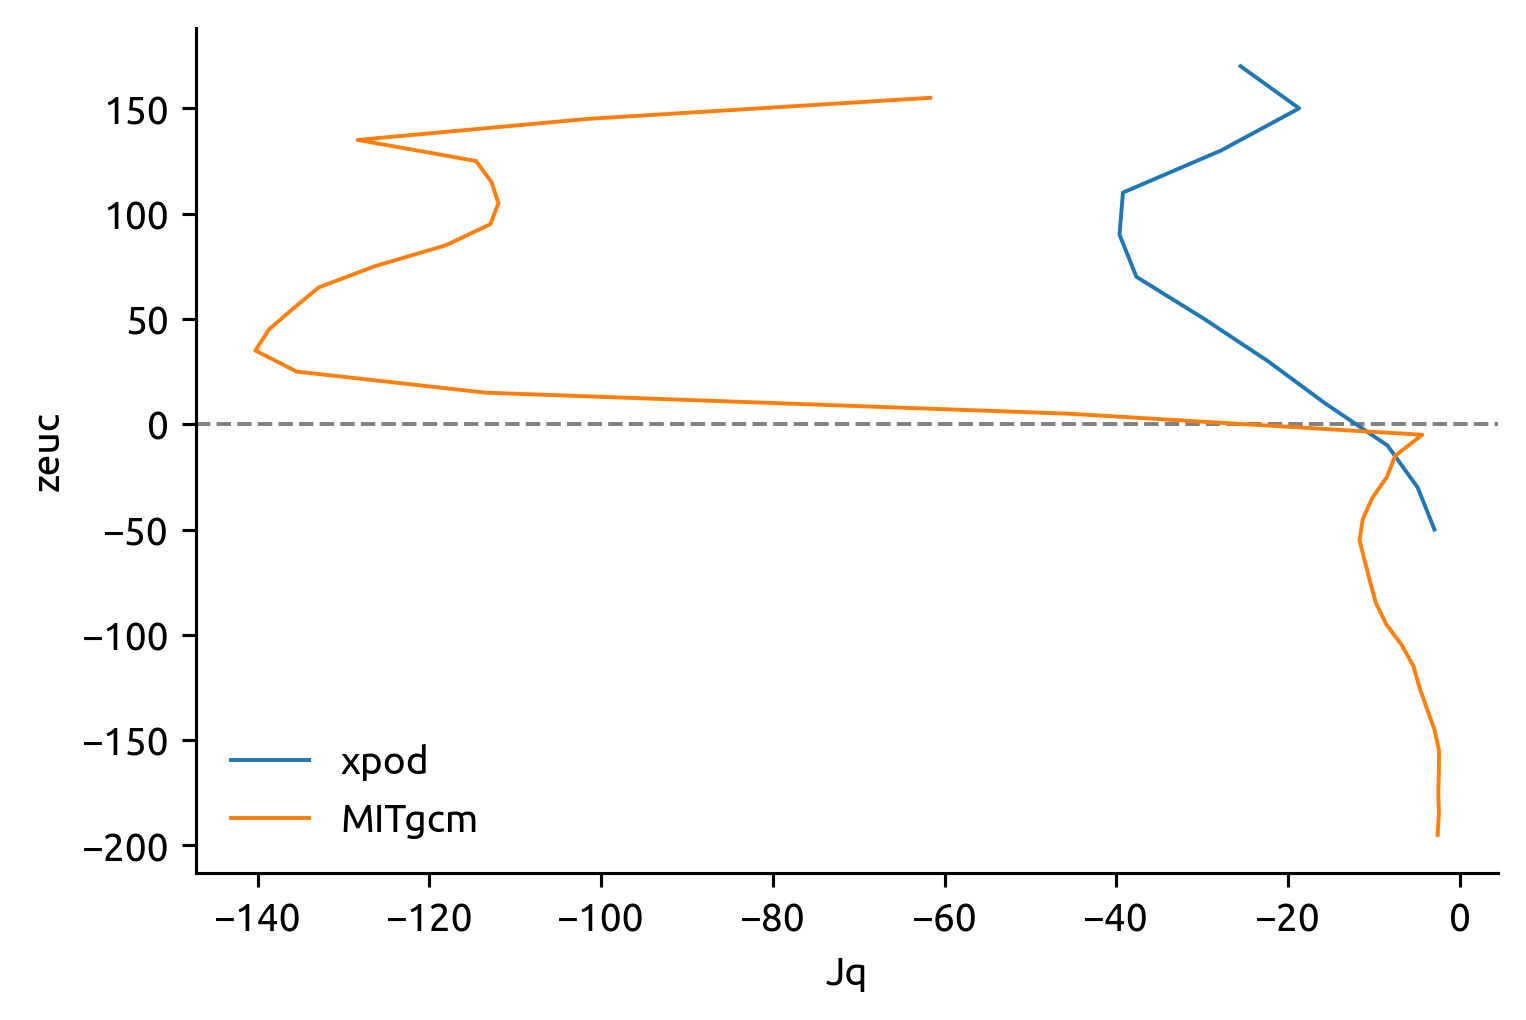

In [86]:
f, ax = plt.subplots(1, 1, sharey=True)
chipod_regridded.Jq.mean("time").plot(y="zeuc")
masked.Jq.mean("time").plot(y="zeuc")
dcpy.plots.liney(0)
plt.legend(["χpod", "MITgcm"])

# masked.u.mean("time").plot(y="zeuc", ax=ax[0])
# chipod_regridded.u.mean("time").plot(y="zeuc", ax=ax[0])

## Divergence in OSU microstructure experiments

In [4]:
th = xr.load_dataset("/home/deepak/datasets/microstructure/osu/tropicheat.nc")
tiwe = xr.load_dataset("/home/deepak/datasets/microstructure/osu/tiwe.nc")
equix = xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix.nc")

for var in equix:
    equix[var].attrs["coordinates"] = " ".join(equix[var].dims)
equix.pden.attrs["standard_name"] = "sea_water_potential_density"
equix.pres.attrs["positive"] = "down"

### Depth-time plots

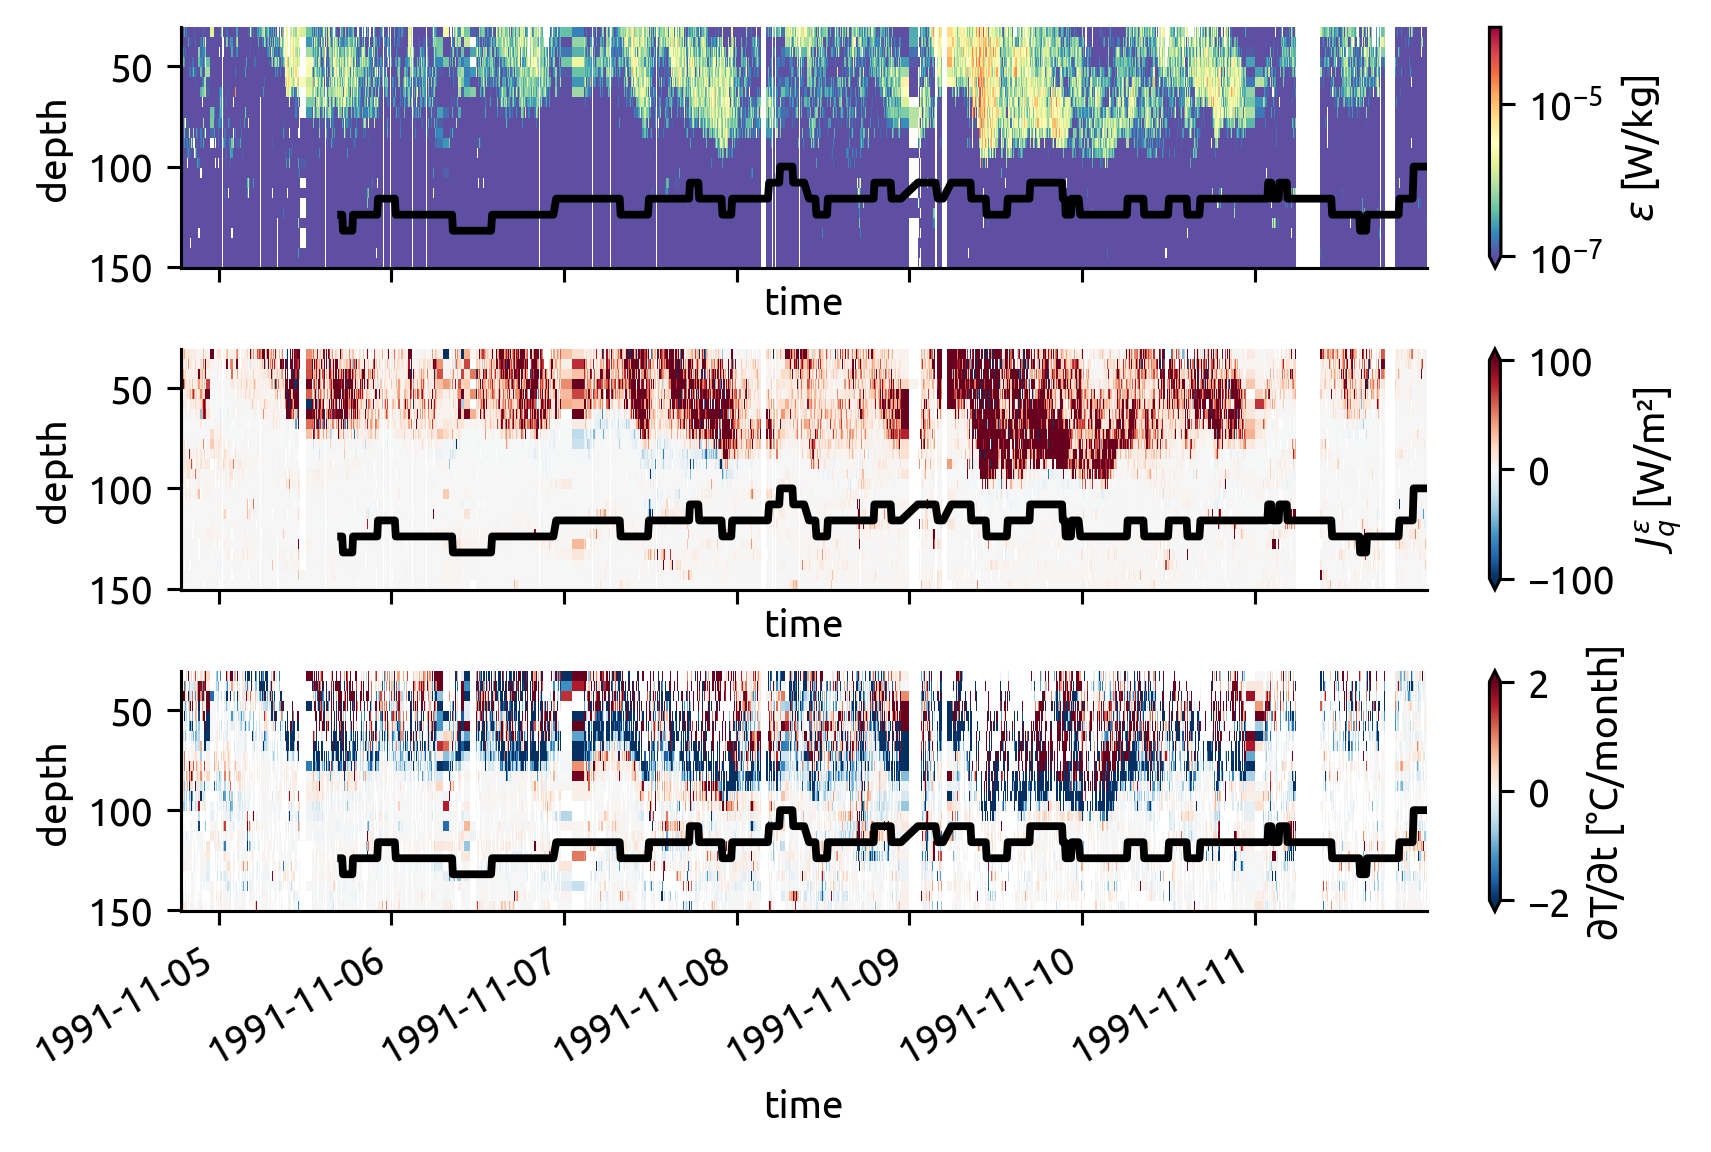

In [4]:
subset = (
    tiwe.coarsen(depth=5, boundary="trim")
    .mean()
    .sel(depth=slice(30, 150), time=slice("1991-11-11"))
)  # .sel(time=slice("1991-11-13", "1991-11-19"))

# subset = (
#    equix.sel(time=slice("2008-10-25", "2008-10-29"))
#    .rolling(depth=5, center=True, min_periods=3)
#    .mean()
#    .sel(depth=slice(125))
# )

f, ax = plt.subplots(3, 1, sharex=True, sharey=True, constrained_layout=True)

subset.eps.where(subset.depth > subset.mld).reset_coords(drop=True).cf.plot(
    norm=mpl.colors.LogNorm(1e-7, 1e-4), ax=ax[0], cmap=mpl.cm.Spectral_r
)
subset.Jq.where(subset.depth > subset.mld).reset_coords(drop=True).cf.plot(
    ax=ax[1], cmap=mpl.cm.RdBu_r, robust=True, vmin=-100
)
subset.dTdt.where(subset.depth > subset.mld).reset_coords(drop=True).cf.plot(
    vmax=-2,
    cmap=mpl.cm.RdBu_r,
    center=0,
    ax=ax[2],
    cbar_kwargs={"label": "∂T/∂t [°C/month]"},
)
# equix.theta.encoding["coordinates"] = "depth time"
# subset.theta.cf.plot.contour(x="time", levels=31)
for aa in ax.flat:
    subset.eucmax.plot(color="k", lw=2, ax=aa, _labels=False)
    # dcpy.plots.liney(iop.depth, ax=aa, zorder=2, color='w')
    # dcpy.plots.liney(eop.depth, ax=aa, zorder=2, color='k')

### Profiles

This didn't work so well

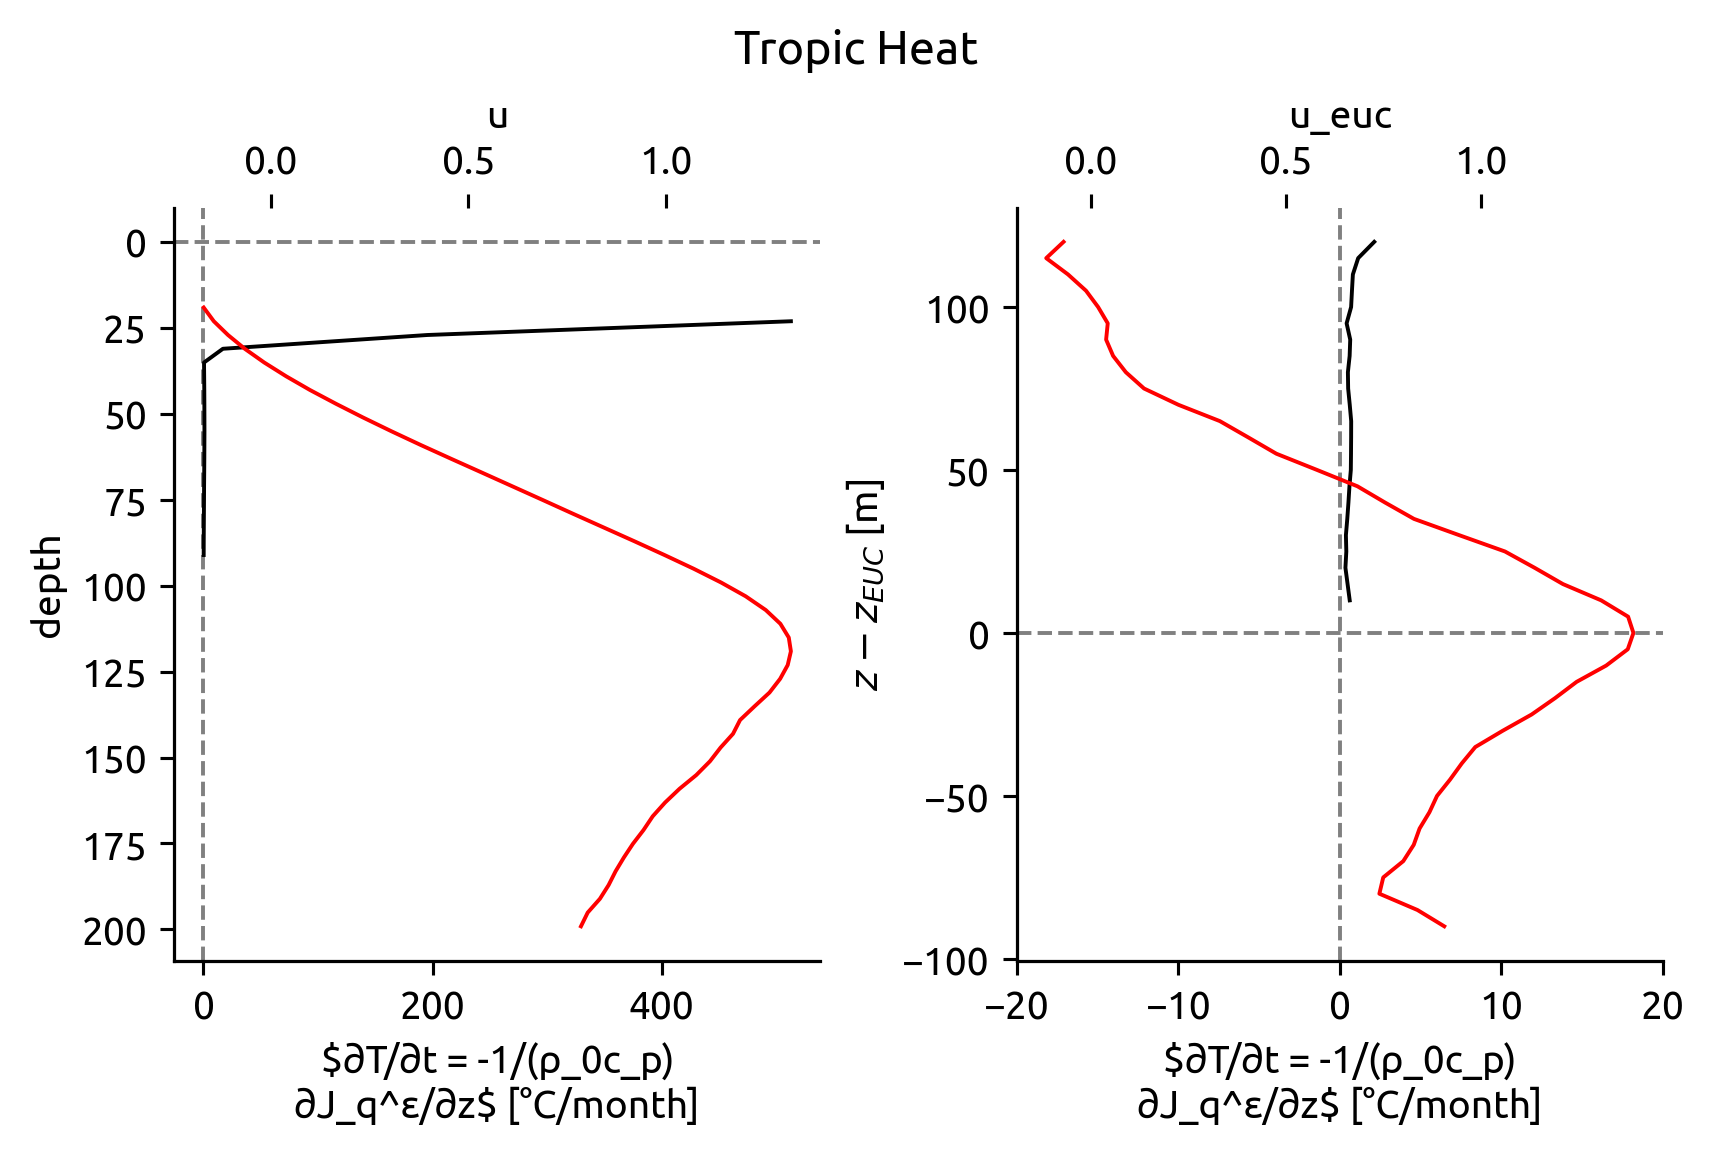

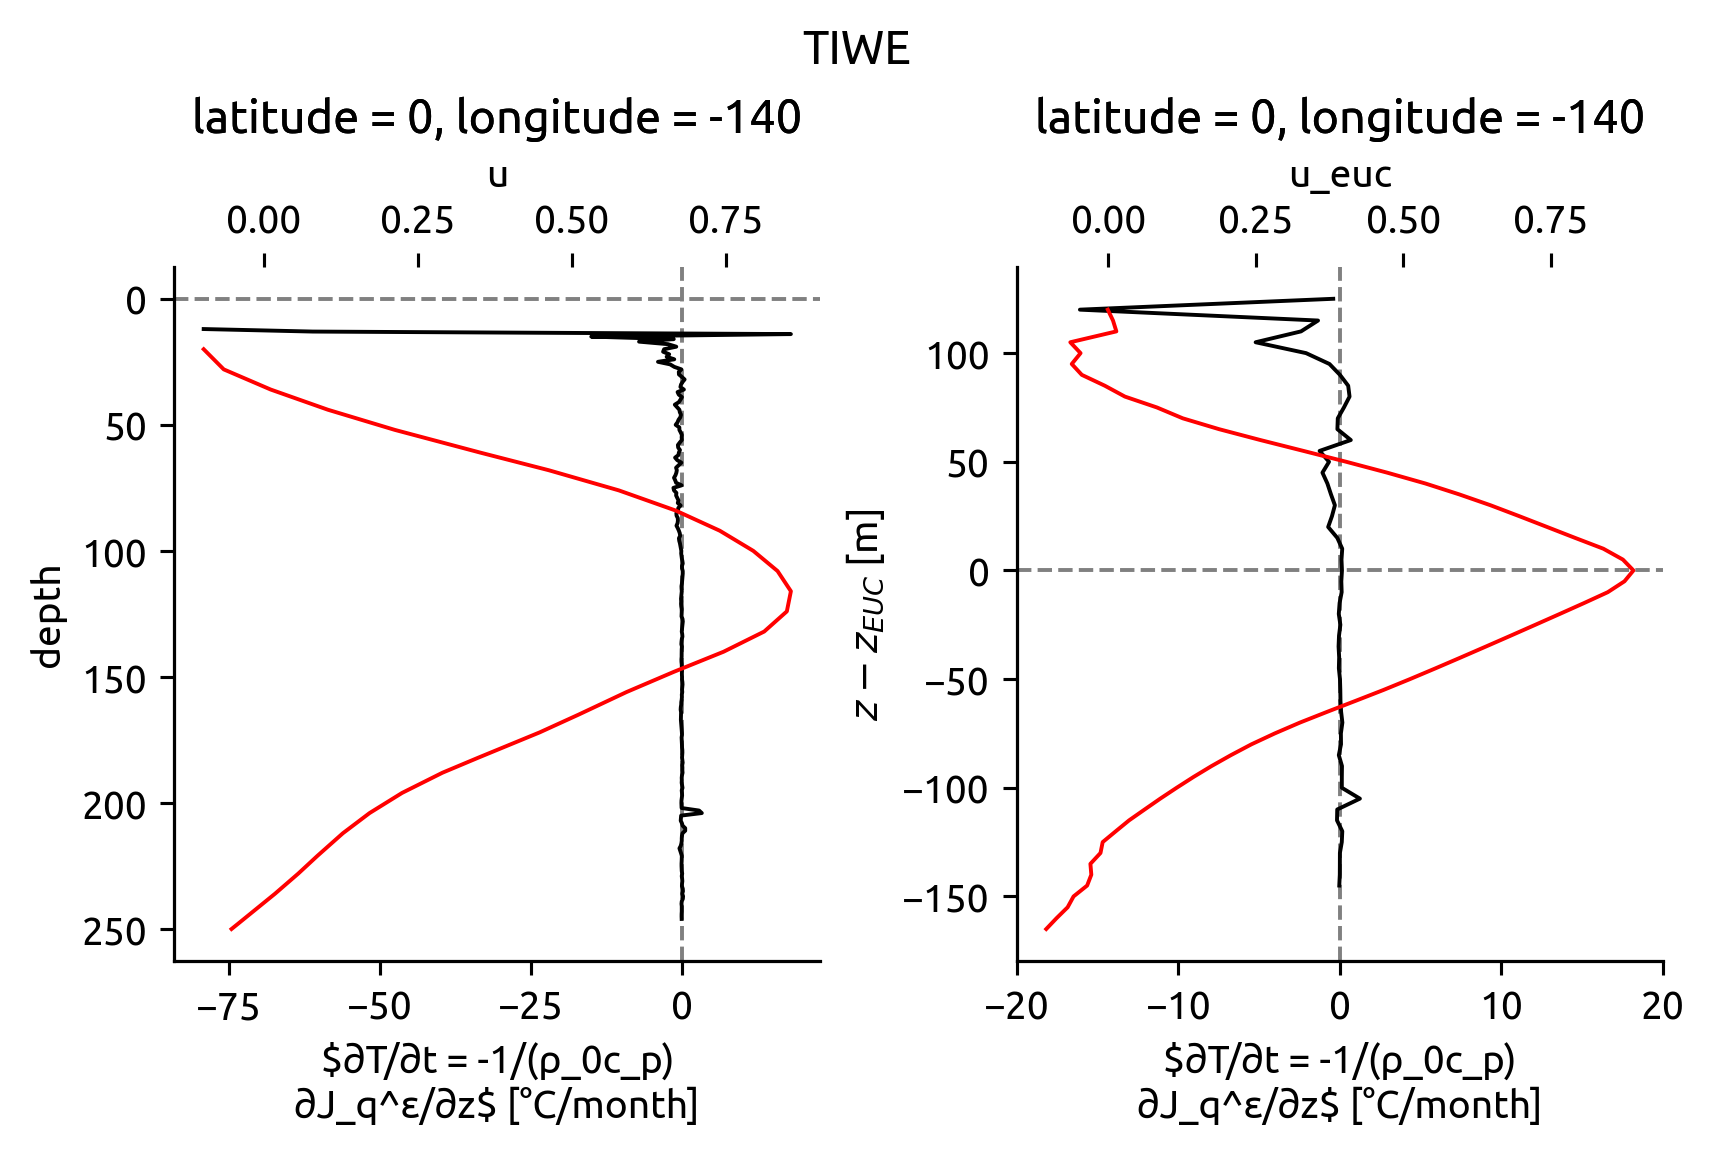

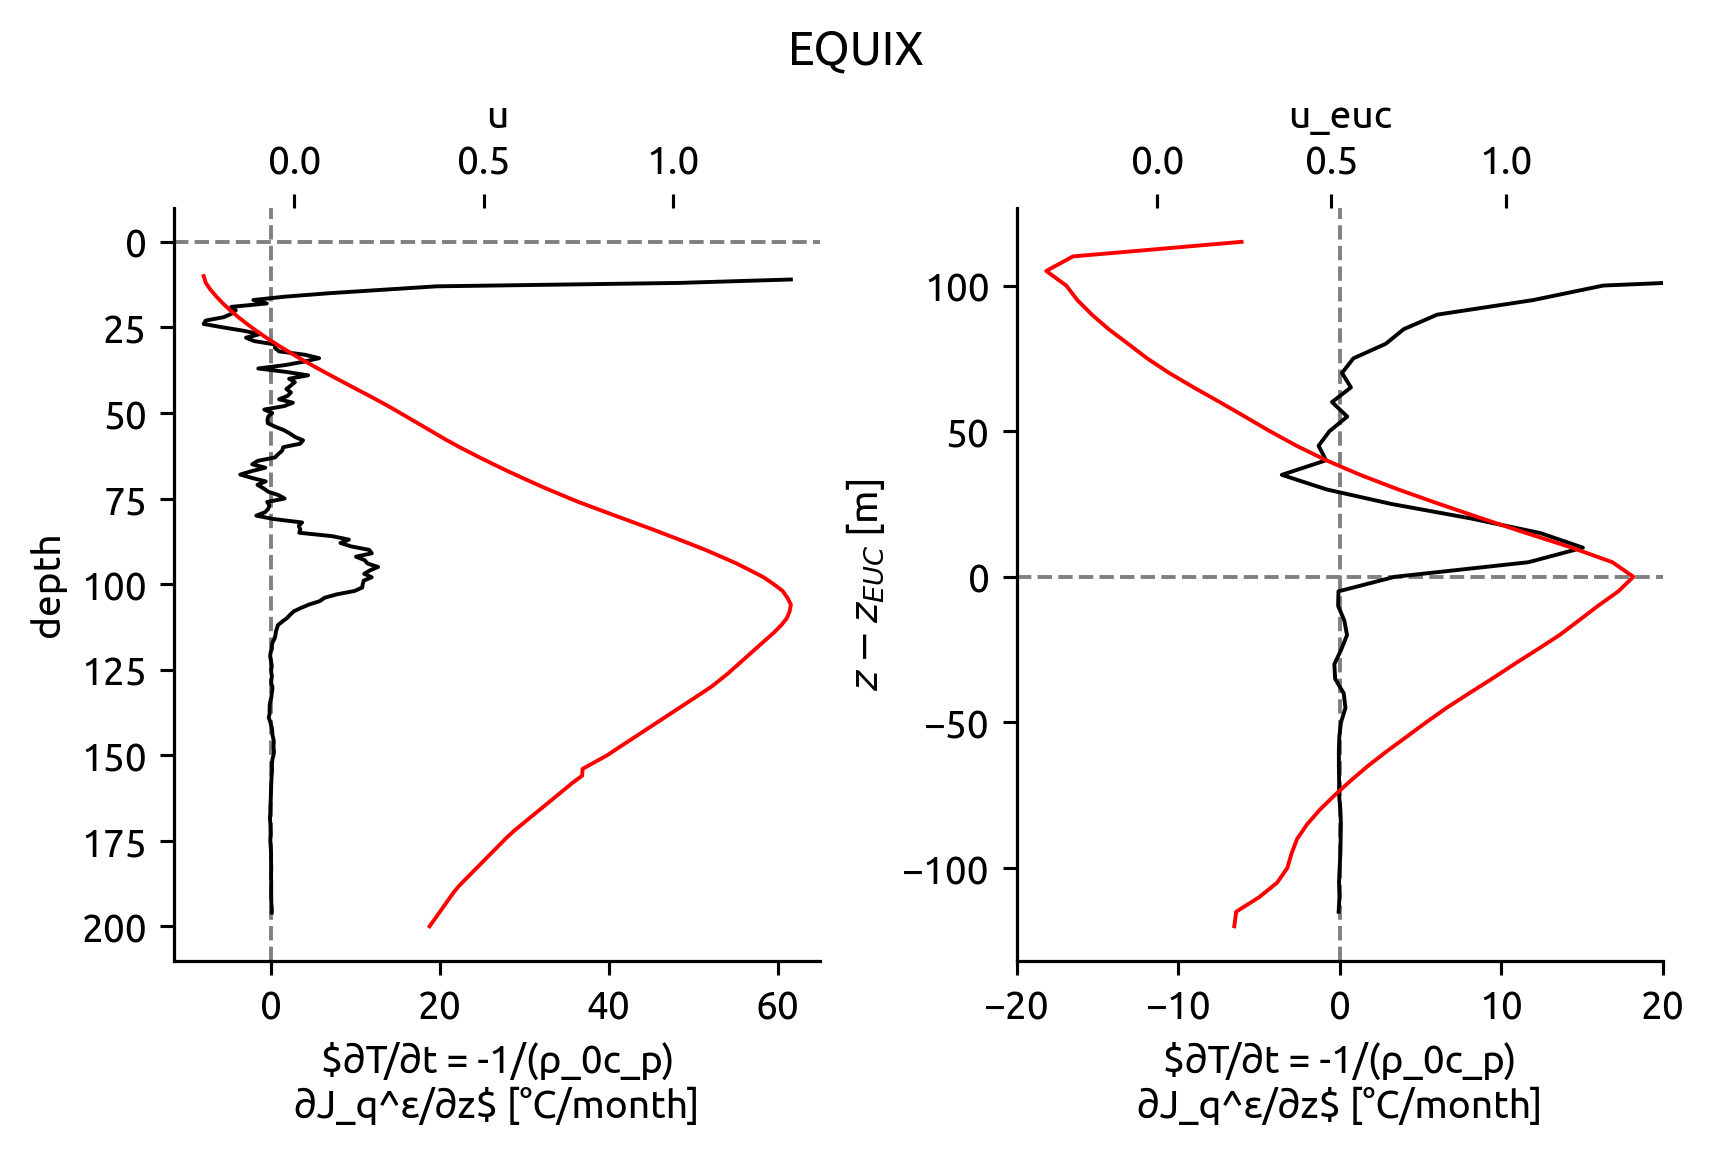

In [89]:
plot_flux_profiles(th)
plot_flux_profiles(tiwe)
plot_flux_profiles(equix)

## EQUIX exploration

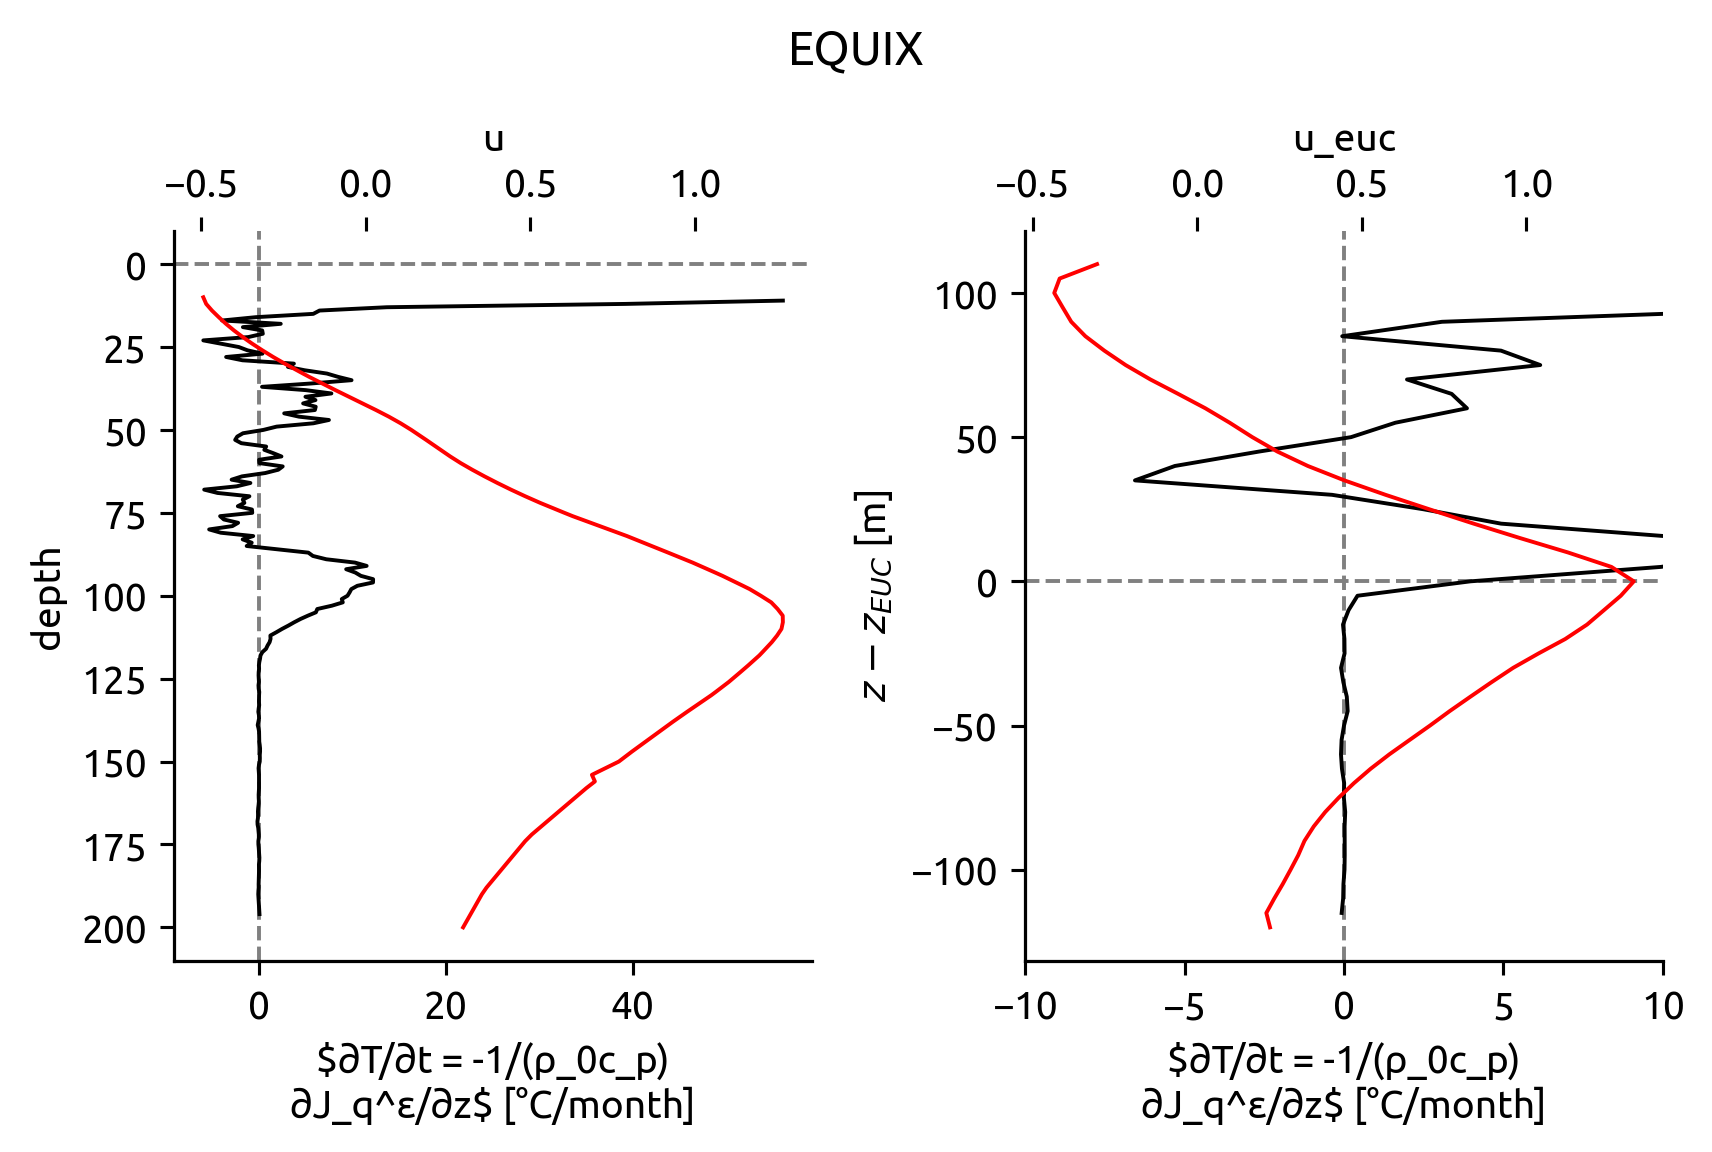

In [355]:
plot_flux_profiles(equix.sel(time=slice("2008-11-01", None)))

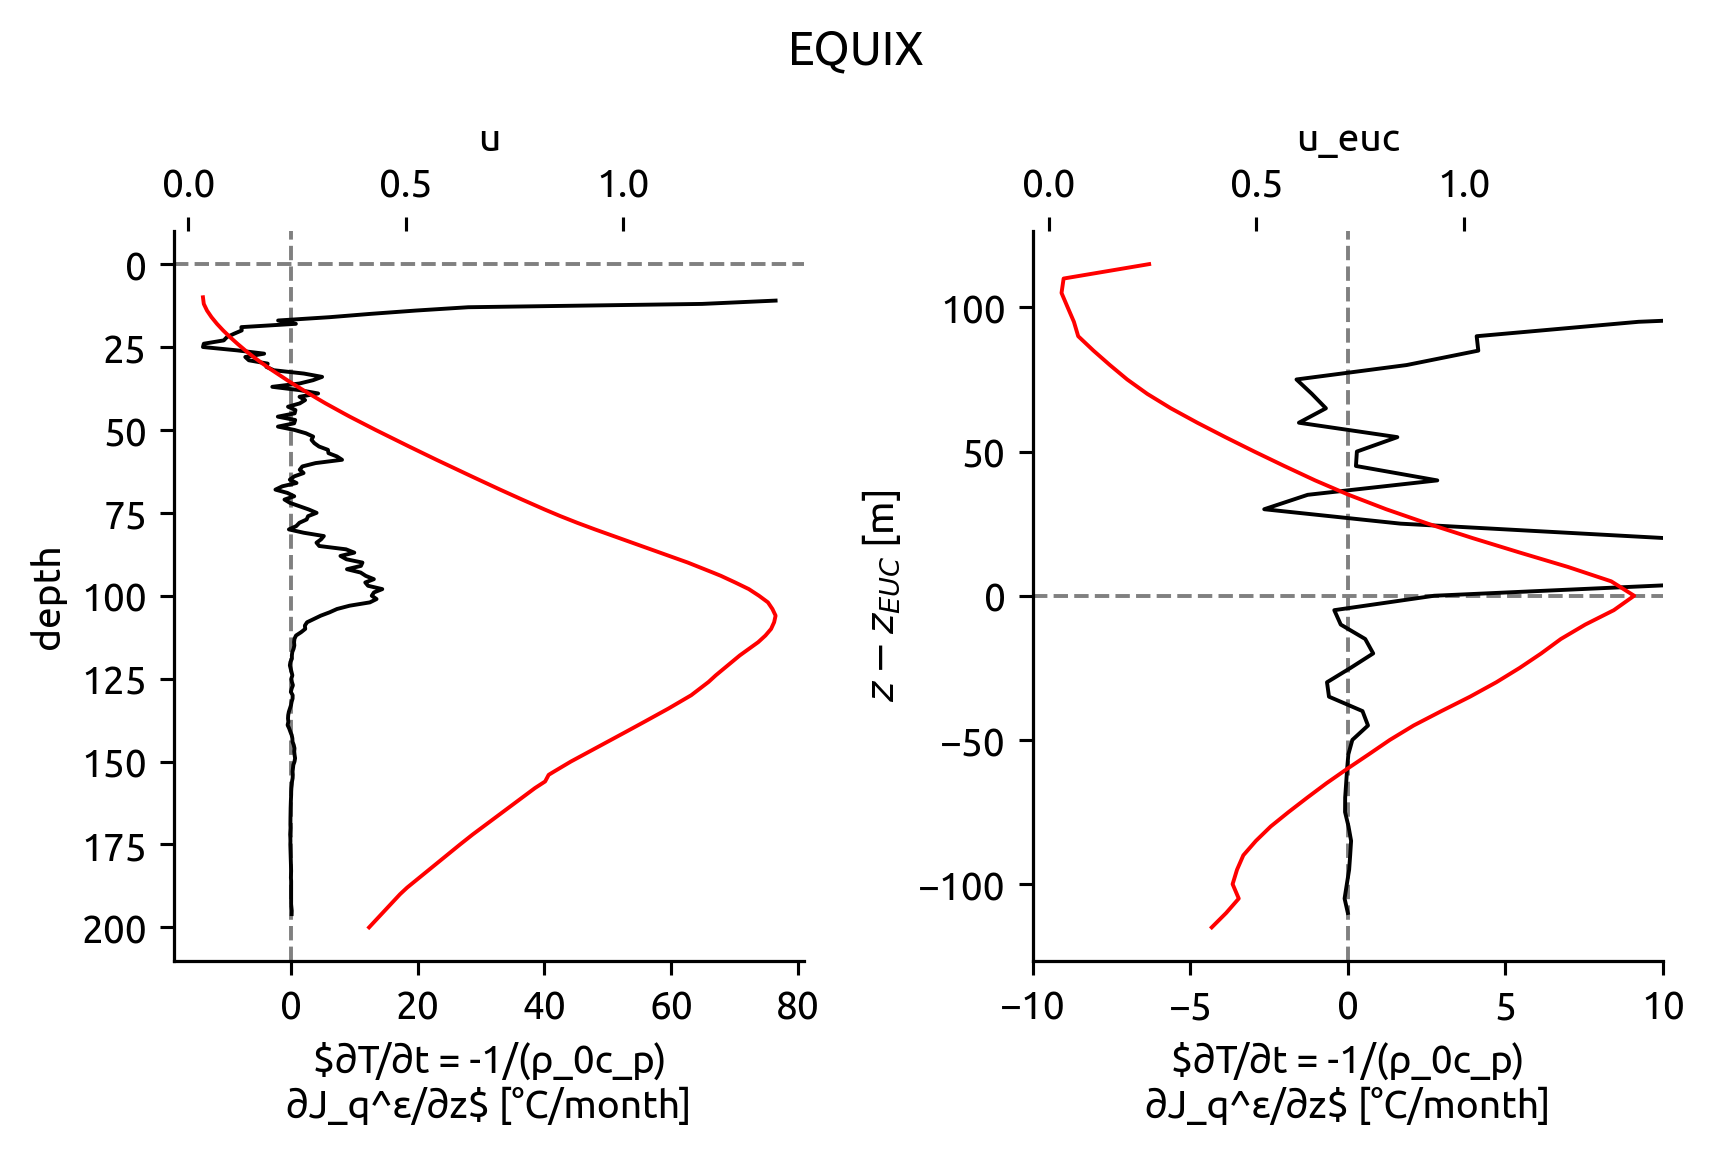

In [356]:
plot_flux_profiles(equix.sel(time=slice("2008-11-01")))

In [149]:
equix["Ri"] = equix.N2.where(equix.N2 > 1e-5) / equix.Sh2.where(equix.Sh2 > 1e-6)

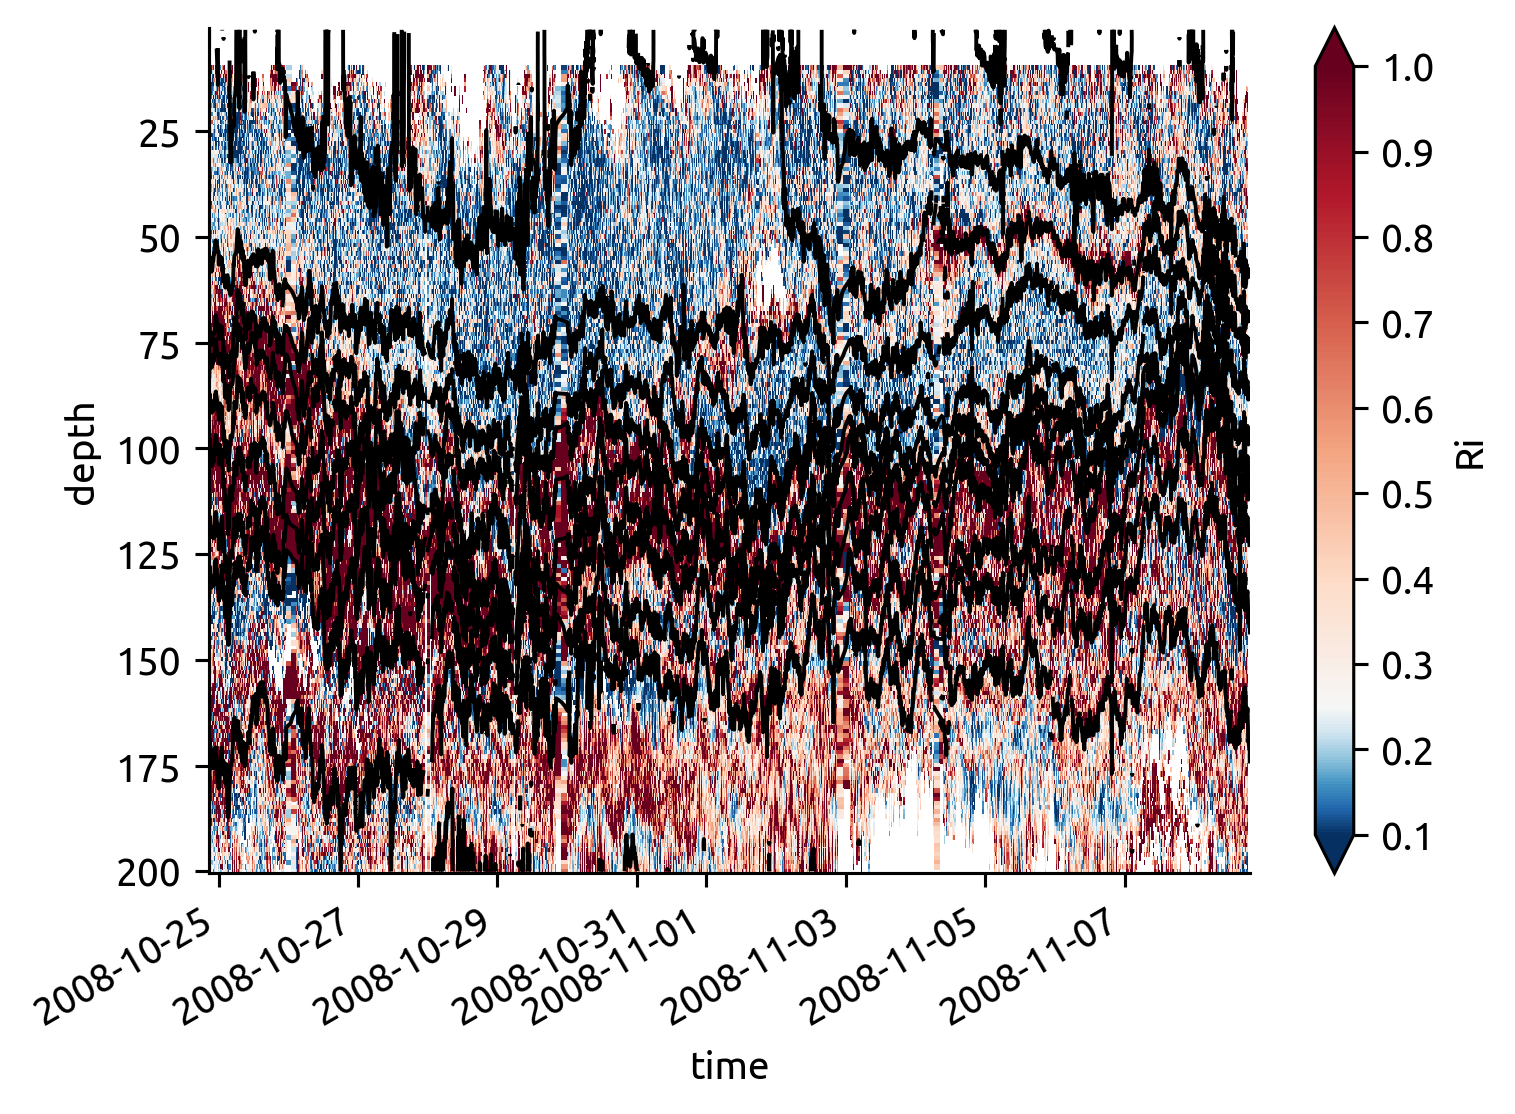

In [167]:
equix.Ri.cf.plot(
    x="time",
    norm=mpl.colors.TwoSlopeNorm(vcenter=0.25, vmin=0.1, vmax=1),
    cmap=mpl.cm.RdBu_r,
)
equix.pden.cf.plot.contour(x="time", levels=21, colors="k")

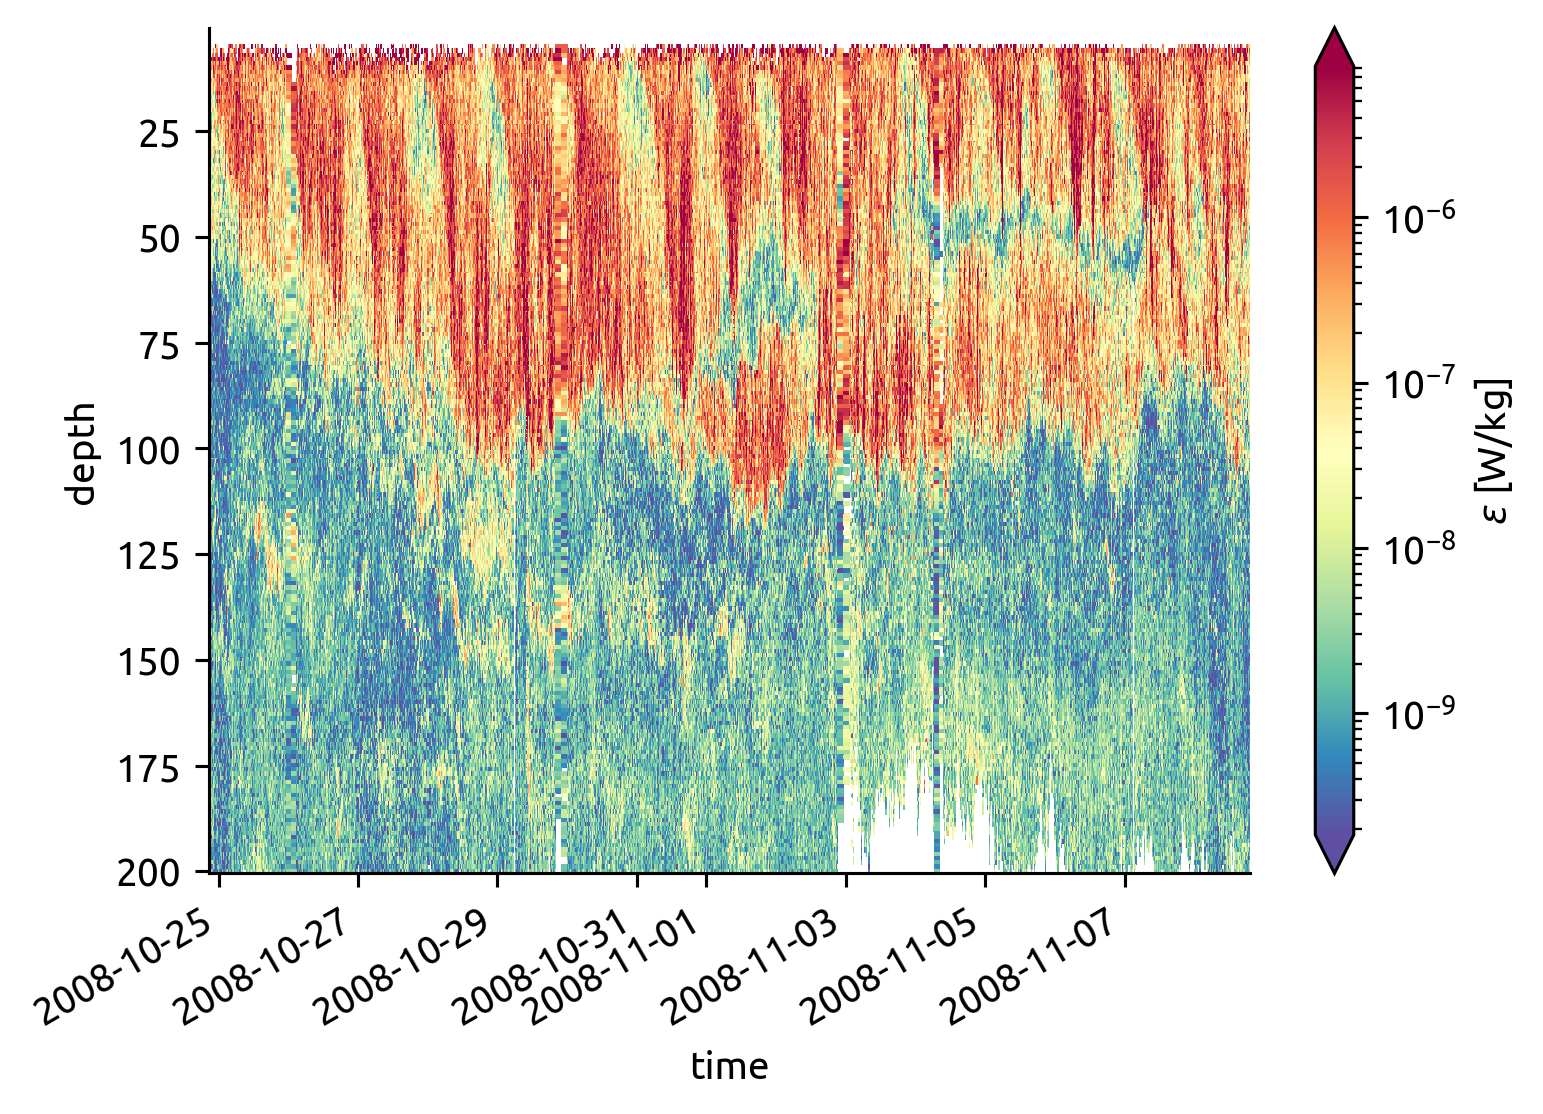

In [133]:
equix.eps.cf.plot(
    x="time", robust=True, norm=mpl.colors.LogNorm(), cmap=mpl.cm.Spectral_r
)

In [2]:
iop = xr.open_dataset(
    "/home/deepak/work/datasets/microstructure/osu/equix/hourly_iop.nc"
)
eop = xr.open_dataset(
    "/home/deepak/work/datasets/microstructure/osu/equix/hourly_eop.nc"
)

iop

<xarray.Dataset>
Dimensions:  (time: 376, depth: 7)
Coordinates:
  * time     (time) datetime64[ns] 2008-10-24T07:00:00 ... 2008-11-08T22:00:00
  * depth    (depth) int64 24 28 49 51 53 62 80
Data variables:
    chi      (time, depth) float64 ...
    theta    (time, depth) float64 ...
    dTdz     (time, depth) float64 ...
    eps      (time, depth) float64 ...
    Kt       (time, depth) float64 ...
    Jq       (time, depth) float64 ...
    KtTz     (time, depth) float64 ...

NameError: name 'iop' is not defined

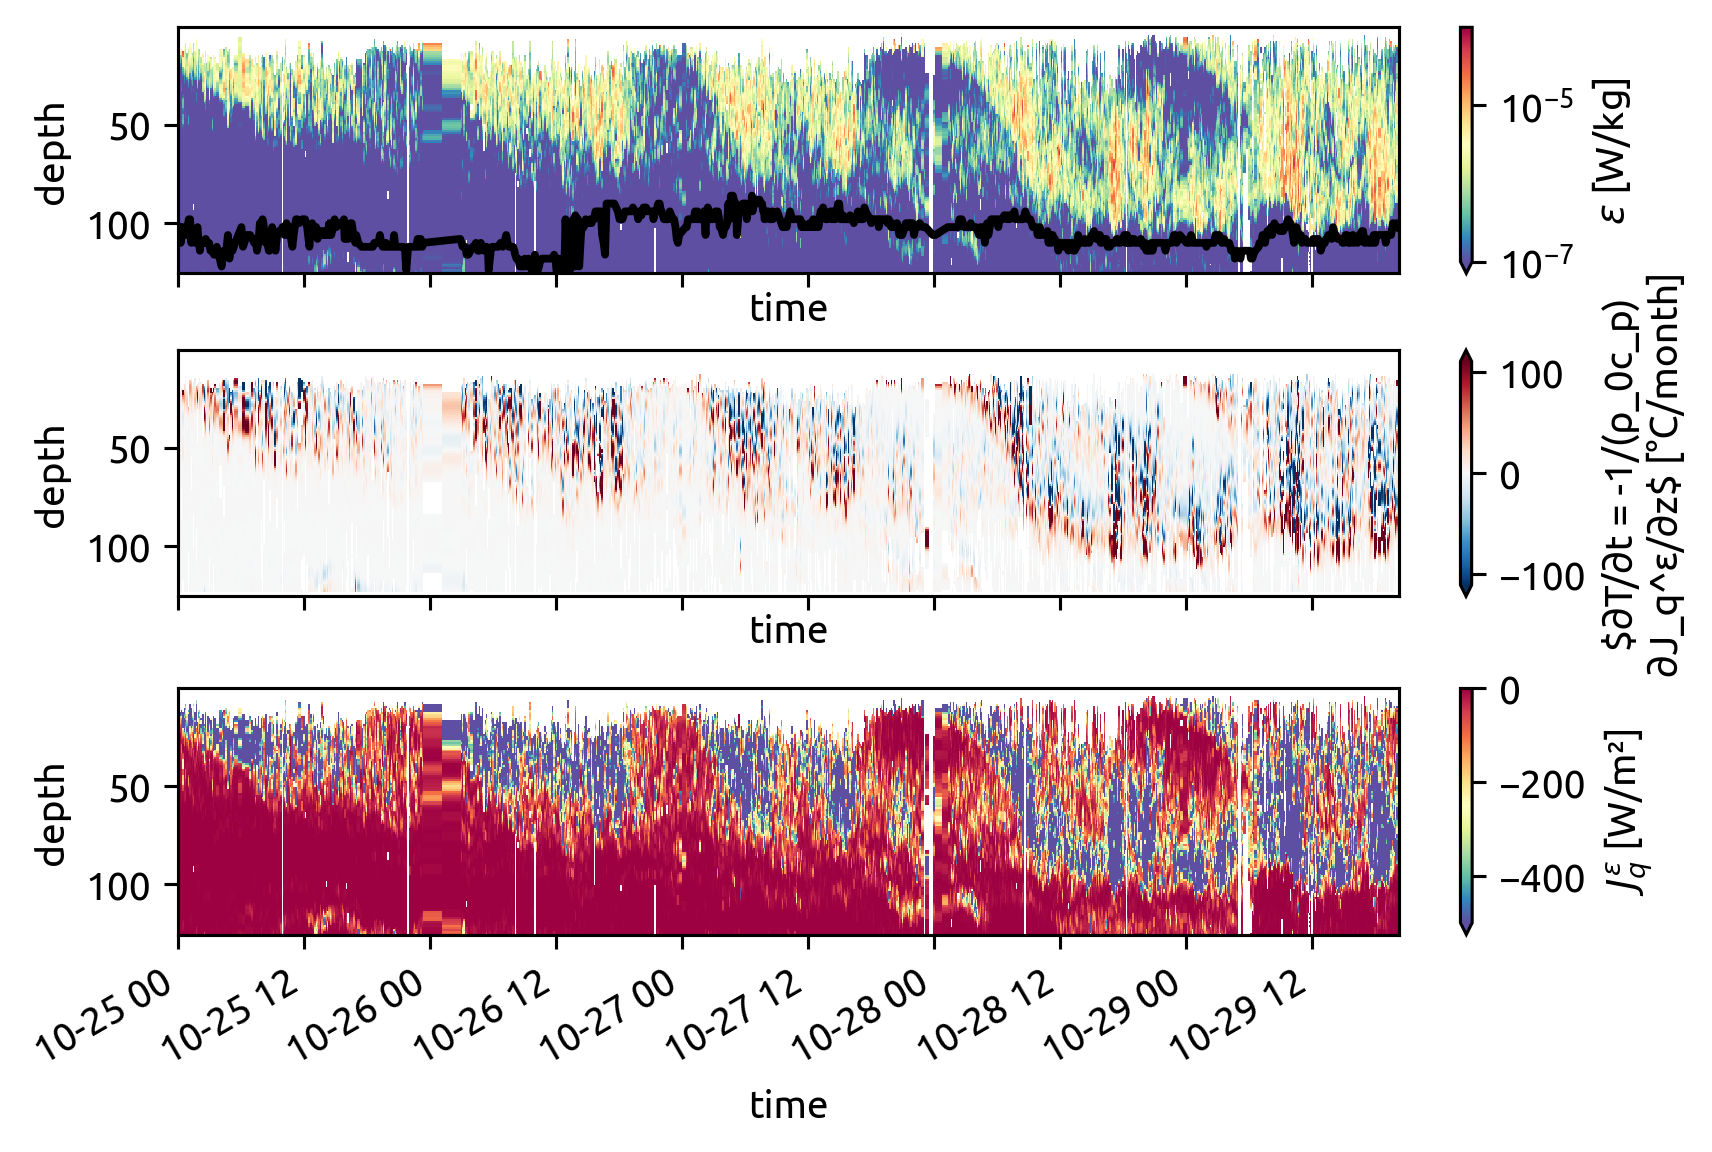

In [18]:
subset = (
    equix.sel(time=slice("2008-10-25", "2008-10-29"))
    .rolling(depth=5, center=True, min_periods=3)
    .mean()
    .sel(depth=slice(125))
)

f, ax = plt.subplots(3, 1, sharex=True, sharey=True, constrained_layout=True)

subset.eps.where(subset.depth > subset.mld).reset_coords(drop=True).cf.plot(
    norm=mpl.colors.LogNorm(1e-7, 1e-4), ax=ax[0], cmap=mpl.cm.Spectral_r
)
subset.Jq.where(subset.depth > subset.mld).reset_coords(drop=True).cf.plot(
    ax=ax[2], cmap=mpl.cm.Spectral_r, robust=True, vmax=0, vmin=-500
)
subset.dTdt.rolling(depth=5, center=True).mean().where(
    subset.depth > subset.mld
).reset_coords(drop=True).cf.plot(
    robust=True,
    cmap=mpl.cm.RdBu_r,
    center=0,
    # cbar_kwargs={"orientation": "horizontal"},
    ax=ax[1],
)
# equix.theta.encoding["coordinates"] = "depth time"
# subset.theta.cf.plot.contour(x="time", levels=31)
for aa in ax.flat:
    subset.eucmax.plot(color="k", lw=2, ax=aa, _labels=False)
    dcpy.plots.liney(iop.depth, ax=aa, zorder=2, color="w")
    dcpy.plots.liney(eop.depth, ax=aa, zorder=2, color="k")

In [ ]:
equix_hourly.eps.cf.plot(
    x="time",
    robust=True,
    norm=mpl.colors.LogNorm(),
    cmap=mpl.cm.Spectral_r,
    cbar_kwargs={"orientation": "horizontal"},
)
equix_hourly.theta.cf.plot.contour(
    x="time", levels=Tbins, linewidths=0.5, colors="k", ylim=(120, 0)
)
plt.tight_layout()

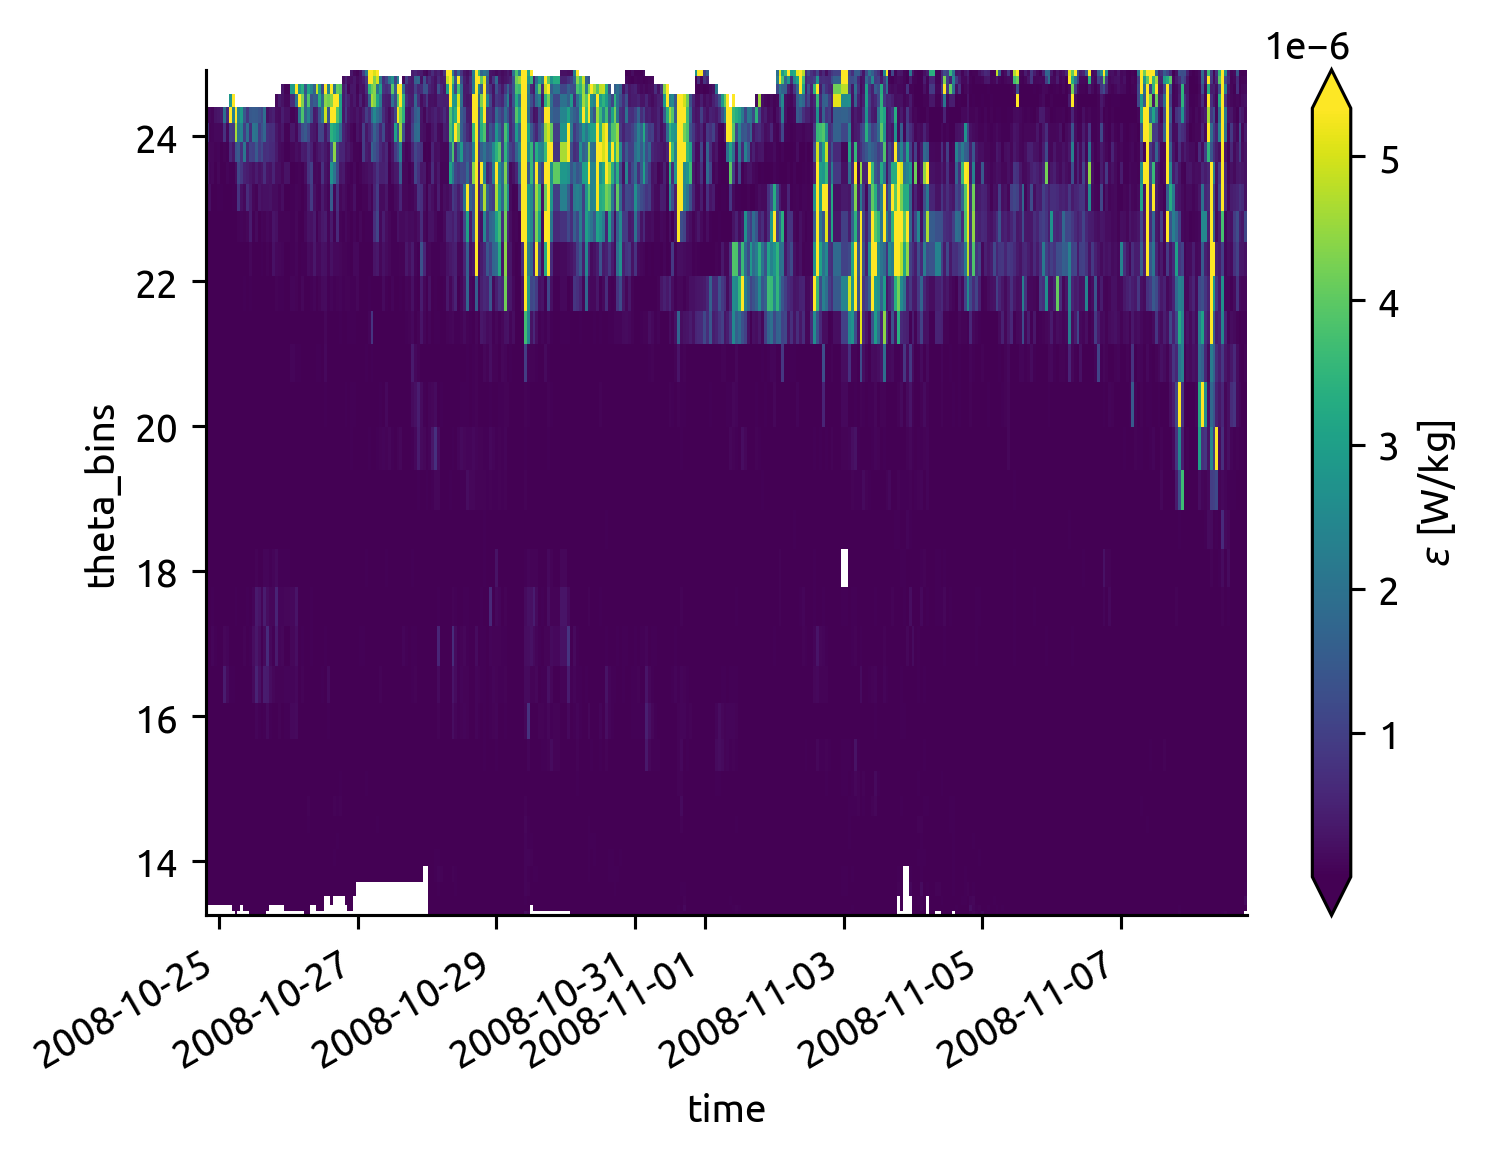

In [22]:
hourly.eps.plot(x="time", robust=True)

In [ ]:
result = (
    equix.sel(time="2008-10-28").groupby("time.hour").map(process_profiles, bins=Tbins)
)

In [122]:
result.coords["zmean"] = ("theta_bins", zmean[::-1])

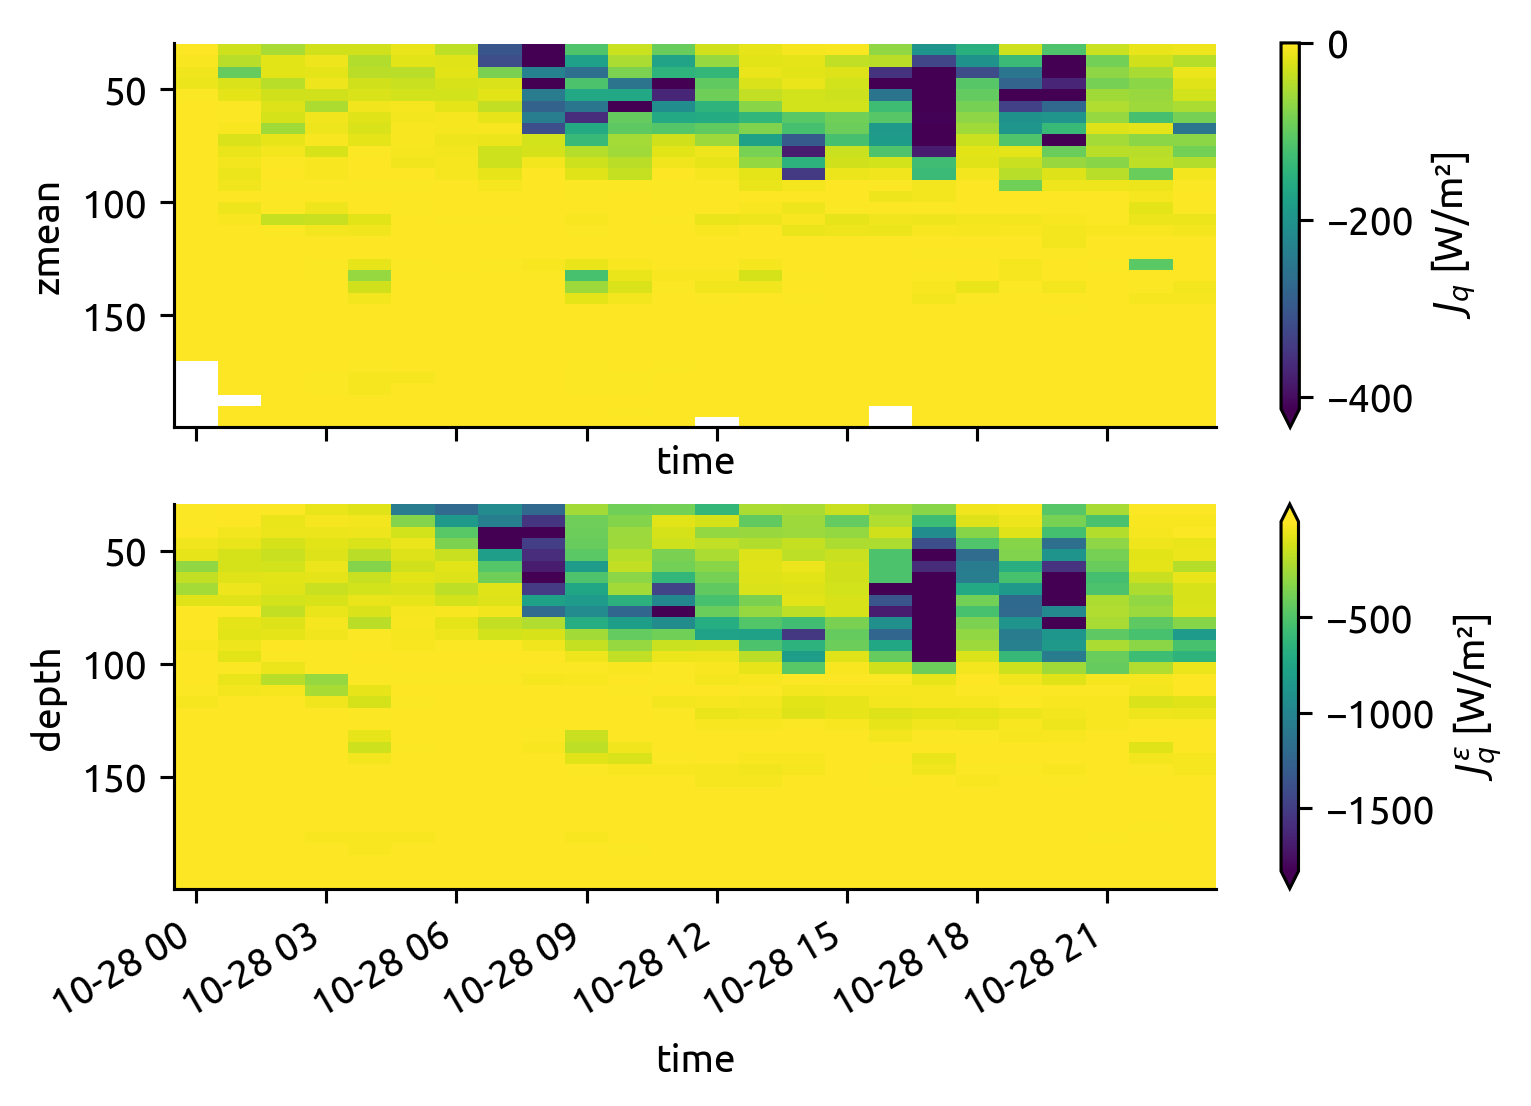

In [132]:
f, ax = plt.subplots(2, 1, sharex=True, sharey=True)
(-1 * result.Jq).plot(x="time", y="zmean", robust=True, yincrease=False, ax=ax[0])
(
    equix.sel(time="2008-10-28")
    .Jq.resample(time="H")
    .mean()
    .sel(depth=slice(30, None))
    .coarsen(depth=5, boundary="trim")
    .mean()
    .cf.plot(robust=True, ax=ax[1])
)

In [141]:
alltime = process_profiles(equix, bins=Tbins)

In [143]:
alltime.coords["zmean"] = ("theta_bins", zmean[::-1])

In [151]:
equix_mean = equix.mean("time")

In [165]:
equix_mean["N2"] = 9.81 / 1025 * equix_mean.pden.differentiate("depth")
equix_mean["dTdz"] = equix_mean.theta.differentiate("depth") ** 2
mean_Jq = -1025 * 4000 * (0.2 * equix_mean.eps / equix_mean.N2) * equix_mean.dTdz

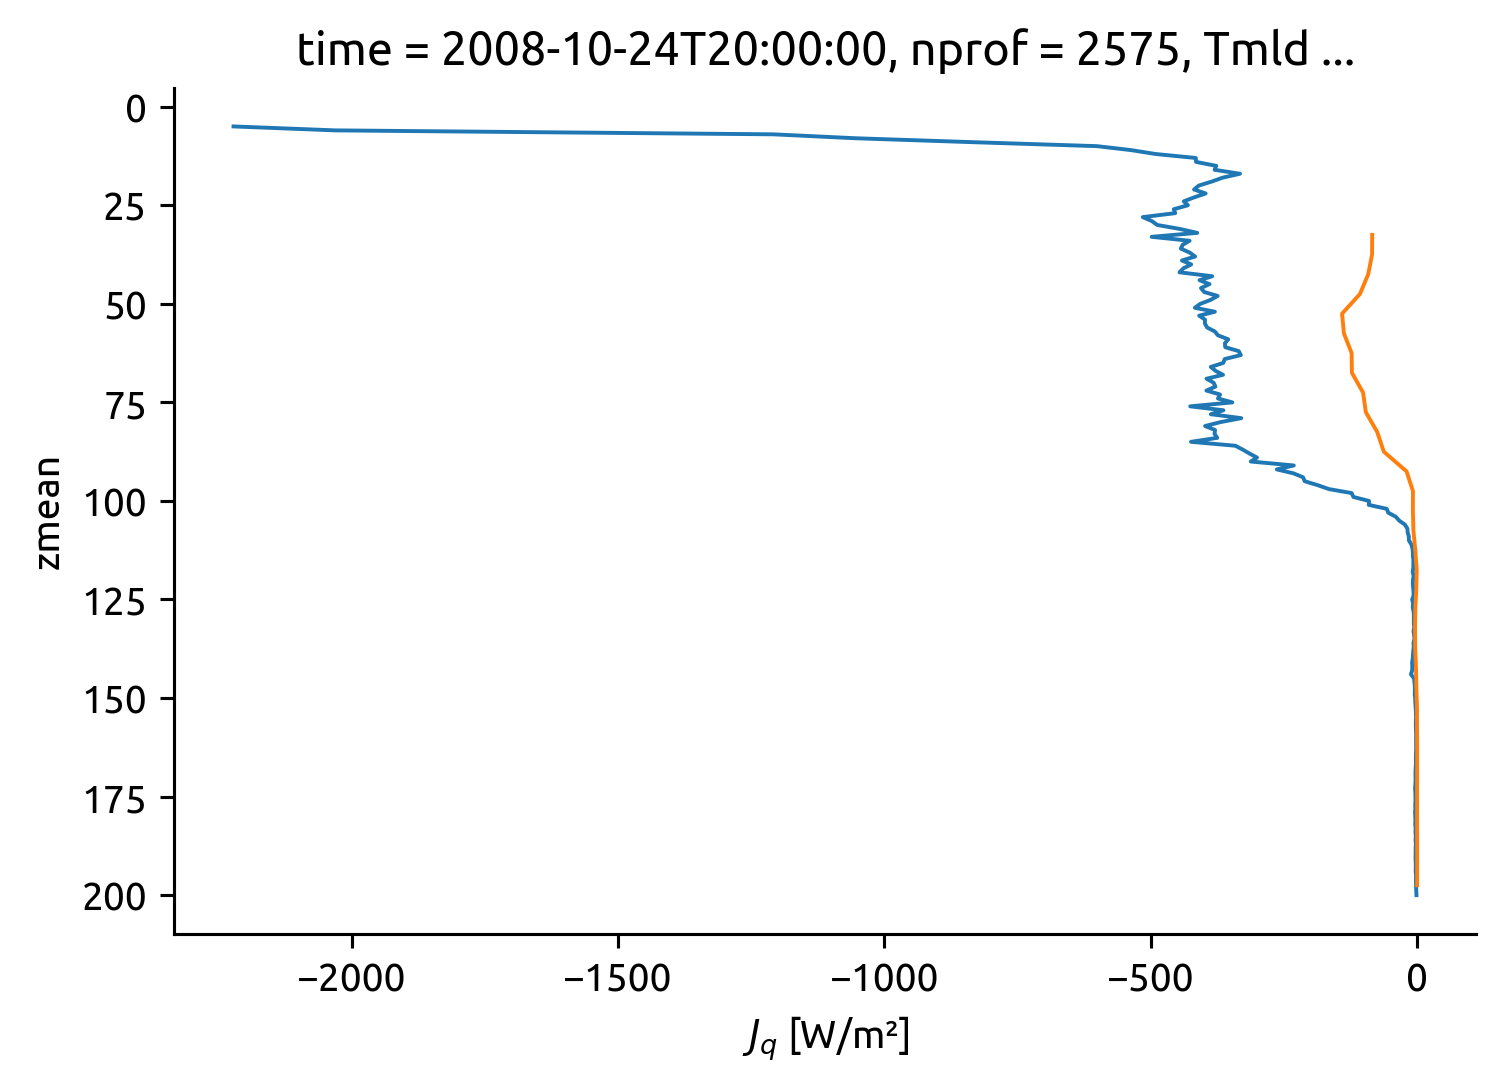

In [179]:
equix.Jq.where(equix.eps < 1e-4).mean("time").cf.plot()
(-1 * alltime.Jq).plot(y="zmean")